## Introduction/Business Problem
In the last number of years, the topic of homelessness has become a political and news topic in Ireland.  The charity Focus Ireland says that there were 10,448 people homeless across Ireland at the end of 2019 (higher than the official government figure of 6,696 homeless persons), and that the number of homeless families has increased by over 300% since November 2014. In the early 2000's Ireland experienced a property bubble followed by a crash in the 2008 global economic downturn.  Since then, the economy has recovered however rate of new house builds have not kept up with the demand resulting in fewer available rental properties.  One of the many factors cited as influencing the availability of rental properties (and as a result homelessness) is the rise in the number of properties being used for short term rental on Airbnb.  In mid 2019 the Irish government enacted the Residential and Tenancies Act 2019 place restrictions to short-term letting in Rent Pressure Zones. Registrations are limited properties rented out for 90 days or less per year  In this study I will analyse Airbnb rentals and homelessness in two Irish cities:
(1) Dublin which is the capital and largest city in Ireland and the city in which I was born.
(2) Cork which is the second largest city in Ireland and the city in which I currently live and work.
The analysis will be used to understand why certain areas of Dublin and Cork have more Airbnb listings,to determine if any insights linking Airbnb to levels of homelessness can be found and to understand if any properties in Rent Pressure Zones could potentially be let through Airbnb for more than 90 days per year in contravention of the new legislation.

## Data
Based on the problem of interest, the information of interest relates to homelessness and Airbnb rentals in the cities of Dublin and Cork.  Folium maps will be used to visualize relevant Airbnb listings in Rent Pressure Zones in Dublin and Cork.
The following data sources will be used to extract the required information and to generate insights:
(1) - Airbnb listings for Dublin and Cork which can be downloaded from the Inside Airbnb website linked below:
http://insideairbnb.com/get-the-data.html
This data includes useful information such as neighbourhood where the property is located (neighbourhood), latitude and longitude, type of property (room_type) as well as number of days per year that the property is available (Availability).
(2) - Official homelessness figures from the Irish Government, Department of Housing, Planning and Local Government available from the website linked below:
https://www.housing.gov.ie/housing/homelessness/other/homelessness-data
(3) New dwelling completiomn data was taken from the Irish Central Statistics Office website linked below:
https://www.cso.ie/en/

In [3]:
# Load & Import Required Libraries
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge folium
import pandas as pd
import numpy as np
from scipy import stats
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



## Generate dataframe of Ireland, Dublin and Cork homeless persons numbers 2014-2019
As there only a small number of data points and the reports containing the official homelessness figures from the Irish Government, Department of Housing,
Planning and Local Government are in pdf format, it was easier to generate the dataframe manually.

In [4]:
# generate Dublin and Cork homeless data lists and dataframe for years 2014-2019
# First generate lists to contain data
hyears = ['2014', '2015', '2016', '2017', '2018', '2019']
irlHome = [2858, 3625, 4643, 5508, 6194, 6696]
dubHome = [1868, 2506, 3162, 3172, 4175, 4534]
corHome =[194, 205, 258, 287, 373, 447]

# Create dataframe of Dublin and Cork Homeless
homeless_df = pd.DataFrame(list(zip(hyears, irlHome, dubHome, corHome)),
                          columns = ('Year', 'Ireland Homeless', 'Dublin Homeless', 'Cork Homeless'))
homeless_df.head(6)

Year  Ireland Homeless  Dublin Homeless  Cork Homeless
0  2014              2858             1868            194
1  2015              3625             2506            205
2  2016              4643             3162            258
3  2017              5508             3172            287
4  2018              6194             4175            373
5  2019              6696             4534            447

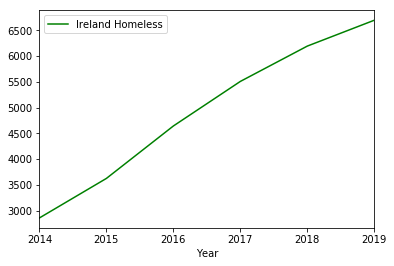

In [5]:
# Generate time series plot of homelessness in Ireland 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Ireland Homeless', color = 'green', ax=ax)
plt.show()

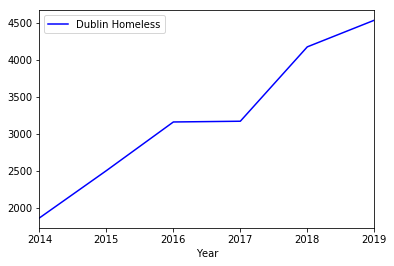

In [6]:
# Generate time series plot of homelessness in Dublin 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Dublin Homeless', color = 'blue', ax=ax)
plt.show()

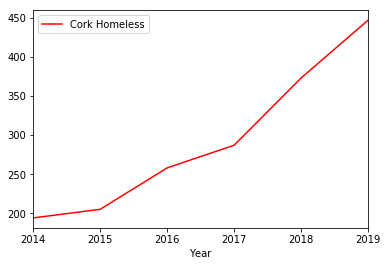

In [7]:
#Generate time series plot of homelessness in Cork 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Cork Homeless', color='red', ax=ax)
plt.show()

As can be seen from the homelessness trends, the number of homeless persons has more than doubled in Ireland, Dublin and Cork in the period of 2014-2019

In [8]:
# Import & clean Ireland new dwelling completions 2000-2012 from CSO website
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
newDwlList_df = pd.read_excel('https://www.cso.ie/en/media/csoie/releasespublications/documents/ep/measuringirelandsprogress/2012/economy/P-MIP2012TBL2.19.xlsx', skiprows=2)

# Eliminate rows with unnecessary data
newDwlList_df = newDwlList_df.drop([0, 1, 2, 3, 4, 5, 19], axis=0).reset_index(drop=True)

# Convert number of dwellings to an integer
newDwlList_df['Number of dwellings'] = newDwlList_df['Number of dwellings'].astype(int)
newDwlList_df.head(30)

Year  Number of dwellings
0   2000                49812
1   2001                52602
2   2002                57695
3   2003                68819
4   2004                76954
5   2005                85957
6   2006                88419
7   2007                78027
8   2008                51724
9   2009                26420
10  2010                14602
11  2011                10480
12  2012                 8488

In [9]:
# generate ireland new dwelling completions data lists and dataframe for years 2013-2019
# This datframe must be created manually as dataset is in pdf format (not a big issue as datset is small)
# First generate lists to contain data
dyears = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
irl_Dwl = [4575, 5518, 7219, 9892, 14368, 17995, 19685]

# Create dataframe of new dwelling completions
newDwl_df = pd.DataFrame(list(zip(dyears, irl_Dwl)),
                          columns = ('Year', 'Number of dwellings'))
newDwl_df.head(7)

Year  Number of dwellings
0  2013                 4575
1  2014                 5518
2  2015                 7219
3  2016                 9892
4  2017                14368
5  2018                17995
6  2019                19685

In [10]:
# Add 2013-2019 dataset to 2000-2012 datset using append function
newDwlFinal_df = newDwlList_df.append(newDwl_df, ignore_index = True)
newDwlFinal_df.head(20)

Year  Number of dwellings
0   2000                49812
1   2001                52602
2   2002                57695
3   2003                68819
4   2004                76954
5   2005                85957
6   2006                88419
7   2007                78027
8   2008                51724
9   2009                26420
10  2010                14602
11  2011                10480
12  2012                 8488
13  2013                 4575
14  2014                 5518
15  2015                 7219
16  2016                 9892
17  2017                14368
18  2018                17995
19  2019                19685

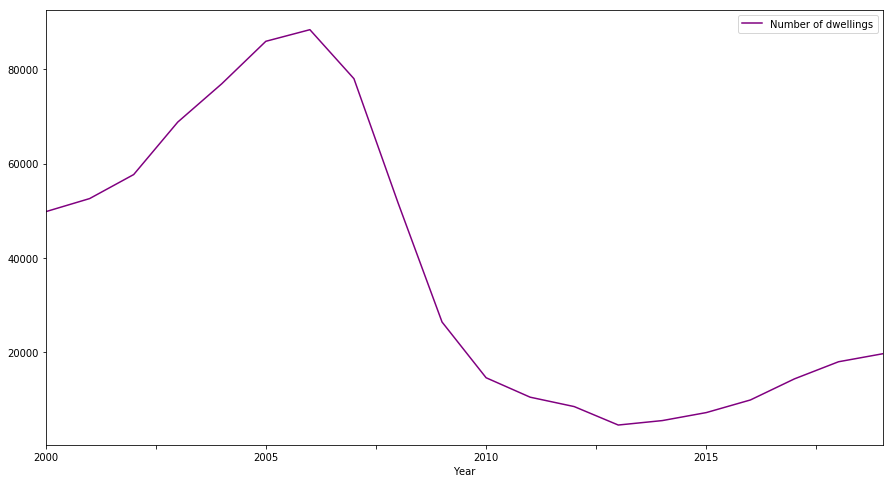

In [94]:
#Generate time series plot of new dwelling completions in Ireland 2011-2019
plt.rcParams['figure.figsize'] = (15,8)
ax = plt.gca()
newDwlFinal_df.plot(kind='line',x='Year',y='Number of dwellings', color='purple', ax=ax)
plt.show()

As can be seen from the data and time series plot, the number of new dwelling completions hit a low of 4,575 in 2013 (about 4-5 years after the property crash of 2008/2009).
Since then the number of new dwelling completions has accelerated rapidly reaching 19,685 in 2019.
Despite this, the number of new dwelling completions is not keeping up with demand as demonstarted by the increasing numbers of homeless.

## Download & Pre-Process Dublin Airbnb Listings

In [12]:
# Download Dublin Airbnb listings csv file
dubList_url='http://data.insideairbnb.com/ireland/leinster/dublin/2019-11-26/visualisations/listings.csv'
dubList_df = pd.read_csv(dubList_url) 
dubList_df.describe()
dubList_df.head(10)

id                                          name  host_id host_name  \
0   44077           cosy comfortable Irish cottage twin   193005    Teresa   
1   85148              Habitación en Dublín Double room   466111       Don   
2   85156  Cosy Comfortable Irish Cottage  1 Double Bed   193005    Teresa   
3  121030           Comfy double room in central area 1   608225     Norah   
4  159889                          Friendly Single Room   766611  Margaret   
5  162809            5.5 miles south of Dublin City :^)   777681    Robbie   
6  165828                Pádraig Pearse apt. Kilmainham   790601   Grainne   
7  165829               The "Michael Collins" apartment   790601   Grainne   
8  178860           Georgian House in Heart of City Ctr   856312  Danielle   
9  181823                   comfy room near beach/town2   608225     Norah   

   neighbourhood_group          neighbourhood  latitude  longitude  \
0                  NaN  Dn Laoghaire-Rathdown  53.28995   -6.25813   
1                  NaN           South Dublin  53.30110   -6.31992   
2                  NaN  Dn Laoghaire-Rathdown  53.29178   -6.25618   
3                  NaN            Dublin City  53.33648   -6.22075   
4                  NaN            Dublin City  53.38988   -6.23620   
5                  NaN  Dn Laoghaire-Rathdown  53.28445   -6.19094   
6                  NaN            Dublin City  53.33630   -6.32439   
7                  NaN            Dublin City  53.33811   -6.32259   
8                  NaN            Dublin City  53.33282   -6.26821   
9                  NaN            Dublin City  53.33650   -6.22066   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     50               3                219  2019-11-25   
1     Private room     30               1                  1  2019-05-11   
2     Private room     50               3                170  2019-11-11   
3     Private room     55               2                110  2019-03-19   
4     Private room     29               1                304  2019-11-24   
5     Private room     55               1                274  2019-11-10   
6  Entire home/apt    147               3                 43  2019-10-22   
7  Entire home/apt    135               3                 51  2019-06-29   
8     Private room     56               2                306  2019-11-22   
9     Private room     75               2                110  2019-11-21   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               2.07                               3               240  
1               0.15                               1                24  
2               1.64                               3               223  
3               1.07                               3                84  
4               3.25                               3               275  
5               5.01                               2                96  
6               0.44                               5               280  
7               0.53                               5               267  
8               3.48                               2               166  
9               1.11                               3                 0

There are two types of property available (Private Room and Entire home/apt)
As this study is particularly interested in the impact of Airbnb on available homes to rent,
the number of Entire home/apt is more relevant than the number of Private room.
It was decided to remove the rows with Private Room as the property type.

In [13]:
# Remove rows where the property type is Private Room
dubList2_df = dubList_df[dubList_df.room_type != 'Private room'].reset_index(drop=True)
dubList2_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

        host_name  neighbourhood_group          neighbourhood  latitude  \
0         Grainne                  NaN            Dublin City  53.33630   
1         Grainne                  NaN            Dublin City  53.33811   
2            Paul                  NaN  Dn Laoghaire-Rathdown  53.27420   
3          Amanda                  NaN            Dublin City  53.39615   
4  Emma And Chris                  NaN            Dublin City  53.32670   
5           Sarah                  NaN                 Fingal  53.36958   
6  Liam And Fiona                  NaN            Dublin City  53.35628   
7  Liam And Fiona                  NaN            Dublin City  53.35561   
8           Diane                  NaN            Dublin City  53.35305   
9         Grainne                  NaN            Dublin City  53.33680   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.32439  Entire home/apt    147               3                 43   
1   -6.32259  Entire home/apt    135               3                 51   
2   -6.10917  Entire home/apt    220               2                141   
3   -6.17456  Entire home/apt     55               2                257   
4   -6.20921  Entire home/apt    248               3                  7   
5   -6.34959  Entire home/apt    120               1                317   
6   -6.28981  Entire home/apt    180               2                 56   
7   -6.29149  Entire home/apt    100               2                 80   
8   -6.25708  Entire home/apt     85               2                181   
9   -6.32410  Entire home/apt    135               3                 28   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-10-22               0.44                               5   
1  2019-06-29               0.53                               5   
2  2019-11-24               1.53                               1   
3  2019-11-17               2.66                               3   
4  2019-07-07               0.07                               1   
5  2019-11-17               3.60                               1   
6  2019-09-25               0.60                               8   
7  2019-09-30               0.85                               8   
8  2019-11-10               1.93                               1   
9  2019-06-30               0.31                               5   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

In [14]:
# Remove rows where the availability_365 is zero
dubList3_df = dubList2_df[dubList2_df.availability_365 != 0].reset_index(drop=True)
dubList3_df.describe()
dubList3_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

        host_name  neighbourhood_group          neighbourhood  latitude  \
0         Grainne                  NaN            Dublin City  53.33630   
1         Grainne                  NaN            Dublin City  53.33811   
2            Paul                  NaN  Dn Laoghaire-Rathdown  53.27420   
3          Amanda                  NaN            Dublin City  53.39615   
4  Emma And Chris                  NaN            Dublin City  53.32670   
5           Sarah                  NaN                 Fingal  53.36958   
6  Liam And Fiona                  NaN            Dublin City  53.35628   
7  Liam And Fiona                  NaN            Dublin City  53.35561   
8           Diane                  NaN            Dublin City  53.35305   
9         Grainne                  NaN            Dublin City  53.33680   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.32439  Entire home/apt    147               3                 43   
1   -6.32259  Entire home/apt    135               3                 51   
2   -6.10917  Entire home/apt    220               2                141   
3   -6.17456  Entire home/apt     55               2                257   
4   -6.20921  Entire home/apt    248               3                  7   
5   -6.34959  Entire home/apt    120               1                317   
6   -6.28981  Entire home/apt    180               2                 56   
7   -6.29149  Entire home/apt    100               2                 80   
8   -6.25708  Entire home/apt     85               2                181   
9   -6.32410  Entire home/apt    135               3                 28   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-10-22               0.44                               5   
1  2019-06-29               0.53                               5   
2  2019-11-24               1.53                               1   
3  2019-11-17               2.66                               3   
4  2019-07-07               0.07                               1   
5  2019-11-17               3.60                               1   
6  2019-09-25               0.60                               8   
7  2019-09-30               0.85                               8   
8  2019-11-10               1.93                               1   
9  2019-06-30               0.31                               5   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

Some of the colums are less relevant for the study.
It was decided to clean up the dataframe by removing the following columns:
host_name
neighbourhood_group
minimum_nights
number_of_reviews
last_review
reviews_per_month

In [15]:
dubListFinal_df = dubList3_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','last_review', 'calculated_host_listings_count'], axis=1)
dubListFinal_df.head(10)                                    

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

           neighbourhood  latitude  longitude        room_type  price  \
0            Dublin City  53.33630   -6.32439  Entire home/apt    147   
1            Dublin City  53.33811   -6.32259  Entire home/apt    135   
2  Dn Laoghaire-Rathdown  53.27420   -6.10917  Entire home/apt    220   
3            Dublin City  53.39615   -6.17456  Entire home/apt     55   
4            Dublin City  53.32670   -6.20921  Entire home/apt    248   
5                 Fingal  53.36958   -6.34959  Entire home/apt    120   
6            Dublin City  53.35628   -6.28981  Entire home/apt    180   
7            Dublin City  53.35561   -6.29149  Entire home/apt    100   
8            Dublin City  53.35305   -6.25708  Entire home/apt     85   
9            Dublin City  53.33680   -6.32410  Entire home/apt    135   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

In [16]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
dubListFinal_df['max_annual_earnings'] = dubListFinal_df['price']*dubListFinal_df['availability_365']
dubListFinal_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

           neighbourhood  latitude  longitude        room_type  price  \
0            Dublin City  53.33630   -6.32439  Entire home/apt    147   
1            Dublin City  53.33811   -6.32259  Entire home/apt    135   
2  Dn Laoghaire-Rathdown  53.27420   -6.10917  Entire home/apt    220   
3            Dublin City  53.39615   -6.17456  Entire home/apt     55   
4            Dublin City  53.32670   -6.20921  Entire home/apt    248   
5                 Fingal  53.36958   -6.34959  Entire home/apt    120   
6            Dublin City  53.35628   -6.28981  Entire home/apt    180   
7            Dublin City  53.35561   -6.29149  Entire home/apt    100   
8            Dublin City  53.35305   -6.25708  Entire home/apt     85   
9            Dublin City  53.33680   -6.32410  Entire home/apt    135   

   availability_365  max_annual_earnings  
0               280                41160  
1               267                36045  
2               232                51040  
3               225                12375  
4                33                 8184  
5               144                17280  
6               325                58500  
7               277                27700  
8               176                14960  
9               277                37395

In [17]:
# Inspect the Dublin Airbnb Listings dataset
dubListFinal_df.describe()

id       host_id     latitude    longitude        price  \
count  2.912000e+03  2.912000e+03  2912.000000  2912.000000  2912.000000   
mean   2.445844e+07  1.003200e+08    53.344722    -6.252321   189.008585   
std    1.097213e+07  9.012047e+07     0.040621     0.052371   282.576011   
min    1.658280e+05  1.922100e+05    53.211130    -6.519370    10.000000   
25%    1.637653e+07  2.414125e+07    53.331815    -6.274235    98.000000   
50%    2.540806e+07  6.857736e+07    53.343910    -6.260060   140.000000   
75%    3.429921e+07  1.624024e+08    53.353450    -6.238465   200.000000   
max    4.037631e+07  3.120656e+08    53.606000    -6.025940  8956.000000   

       availability_365  max_annual_earnings  
count       2912.000000         2.912000e+03  
mean         136.196429         2.832478e+04  
std          115.914312         4.779030e+04  
min            1.000000         4.000000e+01  
25%           37.000000         4.274250e+03  
50%           91.000000         1.391000e+04  
75%          231.250000         3.240000e+04  
max          365.000000         1.128400e+06

In [18]:
print(dubListFinal_df.shape)

(2912, 10)


There are a total of 2,912 relevant Airbnb listings in Dublin which are not single rooms.
As the number of homeless in Dublin is 4,534 persons, even if all of these properties were freed up
for long term rental, it is unlikley that these would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [19]:
# Check the number of Dublin Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
dubList90_df = dubListFinal_df[dubListFinal_df['availability_365']>90]
print(dubList90_df.shape)

(1462, 10)


This is interesting as it indicates that 1,462 of the 2,912 listings (approx. 50%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

In [20]:
# Check the number of Dublin Airbnb listings that are available more than half the year (180 days)
dubList180_df = dubListFinal_df[dubListFinal_df['availability_365']>180]
print(dubList180_df.shape)

(867, 10)


In [21]:
# Check the number of Dublin Airbnb listings that are availble all year round(365 days)
dubList180_df = dubListFinal_df[dubListFinal_df['availability_365']==365]
print(dubList180_df.shape)

(53, 10)


## Download & Pre-Process Cork Airbnb Listings

Because Cork is a much smaller city than Dublin, and very small by international standards there is no separate Airbnb listings dataset available for Cork.
It will be necessary to download the Ireland dataset and extract the Cork city data from it.

In [22]:
# Download Ireland Airbnb listings csv file
ireList_url='http://data.insideairbnb.com/ireland/2019-11-23/visualisations/listings.csv'
ireList_df = pd.read_csv(ireList_url) 
ireList_df.describe()
ireList_df.head(10)

id                                               name    host_id  \
0  20436982  Close to city centre, situated in charming vil...   14893205   
1  39364220                      The perfect Dublin apartment!  302362865   
2  16263733                Double bedroom next to Phoenix park   42059994   
3  40138082              Bright home in a quiet neighbourhood.  172538850   
4   3581384  CONTEMPORARY 3 BEDROOM TOWNHOUSE CENTRAL, SLEE...   17981524   
5  21167665                       Doble bedroom in walkinstown   24183424   
6  15464515   Iveagh Cottage, 3 bedroom warm house with garden   97033971   
7  37226483   A modern 3 bed home with easy access to the city   20214456   
8  13620699  1 bedroom Apt. with full facilities. Close to ...   78889552   
9  13759419  3 Bed Ensuited Space Free Parking & City Tram ...   37019750   

    host_name  neighbourhood_group               neighbourhood  latitude  \
0       Laura  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34940   
1  James Alex  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34772   
2    Nastasia  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34239   
3       Maeve  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32258   
4   Christina  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32697   
5      Marcos  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.31961   
6      Celine  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32899   
7        Mark  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.31804   
8        Mary  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34563   
9       Sammy  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.33509   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.34664  Entire home/apt     90               1                 11   
1   -6.34647  Entire home/apt    110               3                  1   
2   -6.32926     Private room     39               1                  0   
3   -6.32710  Entire home/apt    120               2                  0   
4   -6.31395  Entire home/apt    175              15                 20   
5   -6.32238     Private room     40               3                  1   
6   -6.31619  Entire home/apt    167               2                  8   
7   -6.32237  Entire home/apt    150               2                  2   
8   -6.34237  Entire home/apt     50               1                  3   
9   -6.32970  Entire home/apt     80               2                 18   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                      0  2018-09-18                               1   
1                      1  2019-11-17                               1   
2                      0         NaN                               2   
3                      0         NaN                               1   
4                      9  2019-08-18                               5   
5                      0  2017-10-14                               2   
6                      0  2018-03-08                               1   
7                      2  2019-11-02                               2   
8                      0  2017-09-03                               1   
9                     14  2019-11-17                               1   

   availability_365  
0                 0  
1                20  
2                 0  
3                18  
4                 0  
5                 0  
6               365  
7                 0  
8                 0  
9               108

In [23]:
# Extract Cork city council entries from the dataset
ireList2_df = ireList_df.loc[ireList_df['neighbourhood_group'].isin(['Cork City Council'])].reset_index(drop=True)
ireList2_df.describe()
ireList2_df.head(10)

id                                               name    host_id  \
0  39663754              Matress and sofa for budget traveller   81353277   
1   9548704                       modern open plan 2 bed house   49447447   
2  13344373                House in Cork City centre - 3 rooms   58764063   
3  17735027  Modern & quiet double bed room in Cork City Ce...   33304958   
4  40010839                     Cork City Centre Accommodation   39466924   
5  20578464               Modern bedroom with private bathroom   13108197   
6  33509612          Home from home near Cork City and Airport  252273604   
7  27196730  City centre   1  bedroom apartment own door un...  107437226   
8   3088179  Private Double Room Apartment in the heart of ...     193834   
9  32834364                   3 Altona college road, cork city   56311866   

  host_name neighbourhood_group                  neighbourhood  latitude  \
0        卓霖   Cork City Council  Cork City South Central LEA-6  51.89433   
1     Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
2     David   Cork City Council  Cork City South Central LEA-6  51.88995   
3   Justine   Cork City Council  Cork City South Central LEA-6  51.89922   
4    Sharon   Cork City Council  Cork City South Central LEA-6  51.89304   
5  Jennifer   Cork City Council  Cork City South Central LEA-6  51.89611   
6       Dee   Cork City Council  Cork City South Central LEA-6  51.86900   
7   Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
8     Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
9     Conor   Cork City Council  Cork City South Central LEA-6  51.89221   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.49582     Private room     25               1                  1   
1   -8.46324  Entire home/apt    125               3                 88   
2   -8.47027  Entire home/apt    125               2                 11   
3   -8.47273     Private room     50               1                 16   
4   -8.48385     Private room     90              30                  0   
5   -8.46584     Private room     60               3                 73   
6   -8.46627     Private room     45               2                 16   
7   -8.48618  Entire home/apt     85               1                121   
8   -8.47284  Entire home/apt     49               2                260   
9   -8.48773  Entire home/apt    160               3                  4   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                      1  2019-11-10                               2   
1                     13  2019-10-20                               1   
2                      2  2019-07-07                               1   
3                     16  2019-09-16                               1   
4                      0         NaN                               2   
5                     26  2019-08-01                               1   
6                     16  2019-10-03                               2   
7                     88  2019-11-01                               6   
8                     62  2019-11-24                               1   
9                      4  2019-08-11                               3   

   availability_365  
0                 0  
1               342  
2               168  
3                 0  
4               113  
5                 0  
6                 1  
7               160  
8               184  
9                 0

In [24]:
# Remove rows where the property type is Private Room
ireList3_df = ireList2_df[ireList2_df.room_type != 'Private room'].reset_index(drop=True)
ireList3_df.describe()
ireList3_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  32834364                   3 Altona college road, cork city   56311866   
5  25505651                              City Centre Apartment  192477332   
6  24804603          One bedroom flat in listed Georgian house     907742   
7  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
8  15388361                            9 Magazine rd cork city   56311866   
9  36666968                     Gems Place - Modern Apartment.   42822025   

   host_name neighbourhood_group                  neighbourhood  latitude  \
0      Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
1      David   Cork City Council  Cork City South Central LEA-6  51.88995   
2    Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
3      Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
4      Conor   Cork City Council  Cork City South Central LEA-6  51.89221   
5       Alma   Cork City Council  Cork City South Central LEA-6  51.89704   
6       John   Cork City Council  Cork City South Central LEA-6  51.88932   
7  Lee Point   Cork City Council  Cork City South Central LEA-6  51.89623   
8      Conor   Cork City Council  Cork City South Central LEA-6  51.88914   
9        Gem   Cork City Council  Cork City South Central LEA-6  51.86630   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.48773  Entire home/apt    160               3                  4   
5   -8.47654  Entire home/apt     91               2                 54   
6   -8.46825  Entire home/apt     52              15                101   
7   -8.47748  Entire home/apt    400               1                  0   
8   -8.50054  Entire home/apt    175               2                 23   
9   -8.46725  Entire home/apt     76               2                 43   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                      4  2019-08-11                               3   
5                     18  2019-03-13                               1   
6                     55  2019-09-29                               4   
7                      0         NaN                               3   
8                      7  2019-08-17                               3   
9                     43  2019-11-23                               4   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                 0  
5                 0  
6                90  
7                90  
8                37  
9               287

In [25]:
# Remove rows where the availability_365 is zero
ireList4_df = ireList3_df[ireList3_df.availability_365 != 0].reset_index(drop=True)
ireList4_df.describe()
ireList4_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

   host_name neighbourhood_group                  neighbourhood  latitude  \
0      Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
1      David   Cork City Council  Cork City South Central LEA-6  51.88995   
2    Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
3      Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
4       John   Cork City Council  Cork City South Central LEA-6  51.88932   
5  Lee Point   Cork City Council  Cork City South Central LEA-6  51.89623   
6      Conor   Cork City Council  Cork City South Central LEA-6  51.88914   
7        Gem   Cork City Council  Cork City South Central LEA-6  51.86630   
8      Susan   Cork City Council  Cork City South Central LEA-6  51.89624   
9      Brian   Cork City Council  Cork City South Central LEA-6  51.89426   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.46825  Entire home/apt     52              15                101   
5   -8.47748  Entire home/apt    400               1                  0   
6   -8.50054  Entire home/apt    175               2                 23   
7   -8.46725  Entire home/apt     76               2                 43   
8   -8.46968  Entire home/apt    120               2                295   
9   -8.49226  Entire home/apt    188               1                123   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                     55  2019-09-29                               4   
5                      0         NaN                               3   
6                      7  2019-08-17                               3   
7                     43  2019-11-23                               4   
8                    106  2019-11-24                               1   
9                     42  2019-11-16                               3   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90  
5                90  
6                37  
7               287  
8                60  
9               355

In [26]:
# Remove the uneccessary LEA-6 & LEA-7 suffix on the neighbourhood names
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-6'))
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-7'))
ireList4_df.head()

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   

  host_name neighbourhood_group             neighbourhood  latitude  \
0     Fiona   Cork City Council  Cork City South Central   51.89126   
1     David   Cork City Council  Cork City South Central   51.88995   
2   Anthony   Cork City Council  Cork City South Central   51.89633   
3     Maria   Cork City Council  Cork City South Central   51.89269   
4      John   Cork City Council  Cork City South Central   51.88932   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.46825  Entire home/apt     52              15                101   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                     55  2019-09-29                               4   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90

In [27]:
# Remove unnecessary columns to generate final Cork listings dataframe with the same format as the final Dublin listings dataframe
corListFinal_df = ireList4_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'number_of_reviews', 'number_of_reviews_ltm', 'last_review', 'calculated_host_listings_count',], axis=1).reset_index(drop=True)
corListFinal_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

              neighbourhood  latitude  longitude        room_type  price  \
0  Cork City South Central   51.89126   -8.46324  Entire home/apt    125   
1  Cork City South Central   51.88995   -8.47027  Entire home/apt    125   
2  Cork City South Central   51.89633   -8.48618  Entire home/apt     85   
3  Cork City South Central   51.89269   -8.47284  Entire home/apt     49   
4  Cork City South Central   51.88932   -8.46825  Entire home/apt     52   
5  Cork City South Central   51.89623   -8.47748  Entire home/apt    400   
6  Cork City South Central   51.88914   -8.50054  Entire home/apt    175   
7  Cork City South Central   51.86630   -8.46725  Entire home/apt     76   
8  Cork City South Central   51.89624   -8.46968  Entire home/apt    120   
9  Cork City South Central   51.89426   -8.49226  Entire home/apt    188   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90  
5                90  
6                37  
7               287  
8                60  
9               355

In [28]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
corListFinal_df['max_annual_earnings'] = corListFinal_df['price']*corListFinal_df['availability_365']
corListFinal_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

              neighbourhood  latitude  longitude        room_type  price  \
0  Cork City South Central   51.89126   -8.46324  Entire home/apt    125   
1  Cork City South Central   51.88995   -8.47027  Entire home/apt    125   
2  Cork City South Central   51.89633   -8.48618  Entire home/apt     85   
3  Cork City South Central   51.89269   -8.47284  Entire home/apt     49   
4  Cork City South Central   51.88932   -8.46825  Entire home/apt     52   
5  Cork City South Central   51.89623   -8.47748  Entire home/apt    400   
6  Cork City South Central   51.88914   -8.50054  Entire home/apt    175   
7  Cork City South Central   51.86630   -8.46725  Entire home/apt     76   
8  Cork City South Central   51.89624   -8.46968  Entire home/apt    120   
9  Cork City South Central   51.89426   -8.49226  Entire home/apt    188   

   availability_365  max_annual_earnings  
0               342                42750  
1               168                21000  
2               160                13600  
3               184                 9016  
4                90                 4680  
5                90                36000  
6                37                 6475  
7               287                21812  
8                60                 7200  
9               355                66740

In [29]:
# Inspect the Cork Airbnb Listings dataset
corListFinal_df.describe()

id       host_id    latitude   longitude       price  \
count  1.780000e+02  1.780000e+02  178.000000  178.000000  178.000000   
mean   2.592194e+07  9.845497e+07   51.896259   -8.468609  120.977528   
std    9.973798e+06  8.846174e+07    0.017187    0.036348   64.022238   
min    3.493120e+05  1.938340e+05   51.849730   -8.599050   30.000000   
25%    1.864586e+07  2.839399e+07   51.888747   -8.479360   80.000000   
50%    2.668437e+07  6.555958e+07   51.897095   -8.470430  101.500000   
75%    3.437753e+07  1.578767e+08   51.903295   -8.452690  145.000000   
max    4.027582e+07  3.030647e+08   51.950080   -8.379510  400.000000   

       availability_365  max_annual_earnings  
count        178.000000           178.000000  
mean         174.511236         22321.994382  
std          116.717063         22108.631742  
min            1.000000            70.000000  
25%           71.000000          6186.250000  
50%          166.000000         16000.000000  
75%          300.000000         30952.500000  
max          358.000000        122150.000000

In [30]:
print(corListFinal_df.shape)

(178, 10)


There are a total of 178 relevant Airbnb listings in Cork which are not single rooms.
As the number of homeless in Cork is 447 persons, even if all of these properties were freed up
for long term rental, it would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [31]:
# Check the number of Cork Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
corList90_df = corListFinal_df[corListFinal_df['availability_365']>90]
print(corList90_df.shape)

(119, 10)


Interestingly, 119 of the 178 listings (approx. 67%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

In [32]:
# Check the number of Cork Airbnb listings that are available more than half the year (180 days)
corList180_df = corListFinal_df[corListFinal_df['availability_365']>180]
print(corList180_df.shape)

(75, 10)


In [33]:
# Check the number of Cork Airbnb listings that are available all year round (365 days)
corList365_df = corListFinal_df[corListFinal_df['availability_365']==365]
print(corList365_df.shape)

(0, 10)


## Further Analysis of Dublin and Cork Listings by Neighbourhood

In [34]:
# show unique neighbourhoods in Dublin
print(dubListFinal_df.neighbourhood.unique())

['Dublin City' 'Dn Laoghaire-Rathdown' 'Fingal' 'South Dublin']


Text(0, 0.5, 'Number of Listings')

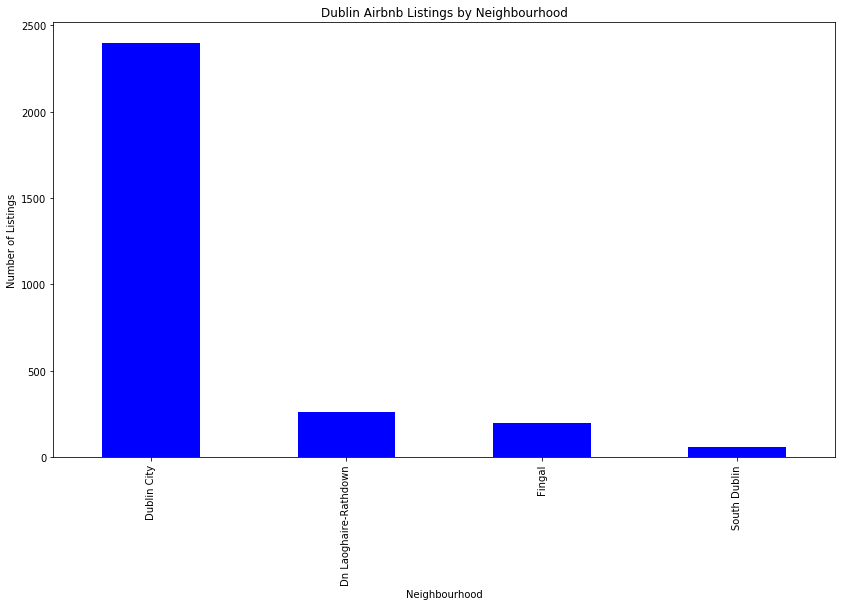

In [35]:
# Generate bar chart to show number of relevant listings in Dublin by neighbourhooddf = df.replace(np.nan,0)
dubHist_df = dubListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Dublin Airbnb Listings by Neighbourhood")
dubHist_df.set_xlabel("Neighbourhood")
dubHist_df.set_ylabel("Number of Listings")

In [36]:
# Determine mean, median, maximum and minimum max_annual_earnings for Dublin
# mean Dublin max_annual_earnings by neighbourhood
dubMean = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(dubMean))

neighbourhood
Dn Laoghaire-Rathdown    28899.0
Dublin City              28849.0
Fingal                   22708.0
South Dublin             23232.0
Name: max_annual_earnings, dtype: float64


In [37]:
# median Dublin max_annual_earnings by neighbourhood
dubMedian = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].median()
print(round(dubMedian))

neighbourhood
Dn Laoghaire-Rathdown    15990.0
Dublin City              13400.0
Fingal                   16272.0
South Dublin              9654.0
Name: max_annual_earnings, dtype: float64


In [38]:
# maximum max_annual_earnings Dublin by neighbourhood
dubMax = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(dubMax))

neighbourhood
Dn Laoghaire-Rathdown     345000
Dublin City              1128400
Fingal                    235200
South Dublin              327000
Name: max_annual_earnings, dtype: int64


In [39]:
# minimum max_annual_earnings Dublin by neighbourhood
dubMin = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(dubMin))

neighbourhood
Dn Laoghaire-Rathdown    150
Dublin City               40
Fingal                    90
South Dublin              76
Name: max_annual_earnings, dtype: int64


In [40]:
# Create dataframe to summarize Dublin max_annual_earning statistics
neighbourhood = ['Dun Laoghaire Rathdown', 'Dublin City', 'Fingal', 'South Dublin']
dubStat = pd.DataFrame(list(zip(neighbourhood, round(dubMean), round(dubMedian), round(dubMax), round(dubMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
dubStat.head()

Neighbourhood     Mean   Median  Maximum  Minimum
0  Dun Laoghaire Rathdown  28899.0  15990.0   345000      150
1             Dublin City  28849.0  13400.0  1128400       40
2                  Fingal  22708.0  16272.0   235200       90
3            South Dublin  23232.0   9654.0   327000       76

In [41]:
# show unique neighbourhoods in Cork
print(corListFinal_df.neighbourhood.unique())

['Cork City South Central ' 'Cork City North East '
 'Cork City North West ' 'Cork City South West ' 'Cork City South East ']


Text(0, 0.5, 'Number of Listings')

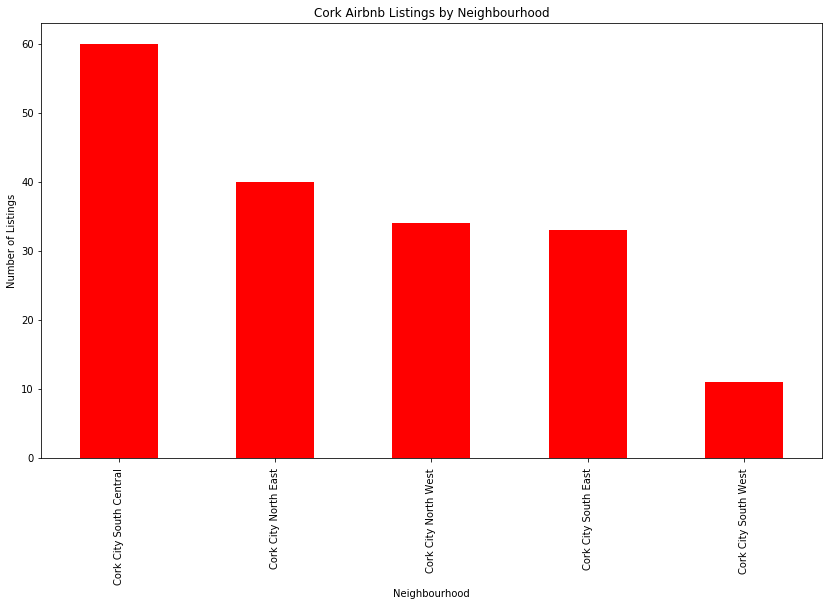

In [42]:
# Generate histogram to show number of relevant listings in Cork by neighbourhood
corHist_df = corListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Cork Airbnb Listings by Neighbourhood")
corHist_df.set_xlabel("Neighbourhood")
corHist_df.set_ylabel("Number of Listings")

In [43]:
# Determine mean, median, maximum and minimum max_annual_earnings by neighbourhood for Cork
# mean Cork max_annual_earnings by neighbourhood
corMean = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMean))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [44]:
# median Cork max_annual_earnings by neighbourhood
corMedian = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMedian))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [45]:
# max Cork max_annual_earnings by neighbourhood
corMax = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(corMax))

neighbourhood
Cork City North East        122150
Cork City North West         84250
Cork City South Central     109800
Cork City South East         60400
Cork City South West        110360
Name: max_annual_earnings, dtype: int64


In [46]:
# min Cork max_annual_earnings by neighbourhood
corMin = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(corMin))

neighbourhood
Cork City North East         70
Cork City North West        325
Cork City South Central     639
Cork City South East        524
Cork City South West        120
Name: max_annual_earnings, dtype: int64


In [47]:
# Create dataframe to summarize Cork max_annual_earning statistics
neighbourhoodC = ['Cork City North East', 'Cork City North West', 'Cork City South Central', 'Cork City South East', 'Cork City South West']
corStat = pd.DataFrame(list(zip(neighbourhoodC, round(corMean), round(corMedian), round(corMax), round(corMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
corStat.head()

Neighbourhood     Mean   Median  Maximum  Minimum
0     Cork City North East  26679.0  26679.0   122150       70
1     Cork City North West  20056.0  20056.0    84250      325
2  Cork City South Central  21003.0  21003.0   109800      639
3     Cork City South East  21377.0  21377.0    60400      524
4     Cork City South West  23515.0  23515.0   110360      120

# Dublin Geospatial Analysis

In [48]:
# Use geopy library to get geographical co-ordinates for Dublin
address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
dublatitude = location.latitude
dublongitude = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(dublatitude, dublongitude))


The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


In [49]:
# Create folium map for Dublin
dub_map = folium.Map(location=[dublatitude, dublongitude], zoom_start=11)
dub_map

In [50]:
# Generate a reduced dataset of 1,000 listings for visualization purposes as 2,912 listings are too large to visualize on a folium map
reddubListFinal_df = dubListFinal_df.head(1000)

# Add markers to the Dublin map for each of the Airbnb Listings
for dlat, dlong, dident in zip(reddubListFinal_df['latitude'], reddubListFinal_df['longitude'], reddubListFinal_df['id']):
    label = "{}".format(dident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [dlat, dlong],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(dub_map)
    
dub_map

## Perform Kmeans Clustering on Dublin Airbnb Listings

In [51]:
# Create new datframe with just id and latittude, longitude for Dublin Airbnb Listing (only Dublin City Centre)

# Remove non City Centre listings
reddubListFinal2_df = reddubListFinal_df[reddubListFinal_df.neighbourhood == 'Dublin City']
reddubListFinal2_df.head(10)

# Create datframe with just id, latitude and longitude
dubKclust_df=reddubListFinal2_df.loc[:,['id','latitude','longitude']]
dubKclust_df.head(10)

id  latitude  longitude
0   165828  53.33630   -6.32439
1   165829  53.33811   -6.32259
3   237465  53.39615   -6.17456
4   275425  53.32670   -6.20921
6   302554  53.35628   -6.28981
7   302634  53.35561   -6.29149
8   365854  53.35305   -6.25708
9   374792  53.33680   -6.32410
10  386860  53.33759   -6.27460
11  419987  53.35651   -6.29229

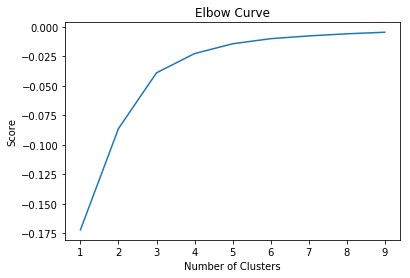

In [52]:
# Create Elbow curve to determine correct number of clusters
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dubKclust_df[['latitude']]
X_axis = dubKclust_df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [53]:
# Perform kmeans clustering on Dublin Airbnb and add to datframe
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(dubKclust_df[dubKclust_df.columns[1:3]]) # Compute k-means clustering.
dubKclust_df['cluster_label'] = kmeans.fit_predict(dubKclust_df[dubKclust_df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(dubKclust_df[dubKclust_df.columns[1:3]]) # Labels of each point
dubKclust_df.head(100)

id  latitude  longitude  cluster_label
0     165828  53.33630   -6.32439              3
1     165829  53.33811   -6.32259              3
3     237465  53.39615   -6.17456              1
4     275425  53.32670   -6.20921              2
6     302554  53.35628   -6.28981              0
7     302634  53.35561   -6.29149              3
8     365854  53.35305   -6.25708              0
9     374792  53.33680   -6.32410              3
10    386860  53.33759   -6.27460              0
11    419987  53.35651   -6.29229              3
12    424596  53.35456   -6.25886              0
13    427077  53.35593   -6.25751              0
14    451611  53.34109   -6.27175              0
15    454183  53.35391   -6.29800              3
16    522667  53.35526   -6.25734              0
17    526767  53.34769   -6.26388              0
18    654589  53.34489   -6.26804              0
23    800026  53.36825   -6.25039              2
24    816039  53.36609   -6.32459              3
26    872539  53.35799   -6.23991              2
27    922425  53.34248   -6.27240              0
28    928970  53.34246   -6.23910              2
29    939866  53.34370   -6.23975              2
30    946923  53.34539   -6.23873              2
31    998407  53.39729   -6.17521              1
32    999963  53.36181   -6.27475              0
33   1076514  53.34652   -6.24697              2
34   1086416  53.35787   -6.27497              0
36   1265520  53.36777   -6.27172              0
37   1276002  53.35190   -6.23396              2
..       ...       ...        ...            ...
85   3096382  53.34466   -6.26698              0
87   3238040  53.32871   -6.25337              4
91   3345276  53.34249   -6.26706              0
92   3374950  53.35732   -6.24464              2
93   3389175  53.34013   -6.27371              0
94   3411757  53.33867   -6.30322              3
95   3448070  53.34168   -6.30349              3
96   3495749  53.33424   -6.29294              3
97   3529607  53.33464   -6.29369              3
98   3540733  53.31075   -6.28624              4
99   3550489  53.38057   -6.23695              2
100  3591840  53.33398   -6.29307              3
101  3592153  53.33199   -6.22741              2
102  3592455  53.33672   -6.25631              4
103  3604420  53.34681   -6.22693              2
104  3604440  53.34231   -6.23590              2
105  3634410  53.33832   -6.23847              2
106  3634993  53.33363   -6.28174              4
107  3665546  53.34796   -6.26511              0
108  3795879  53.34504   -6.26857              0
109  3850497  53.35854   -6.26933              0
110  3858756  53.34259   -6.27110              0
112  3882631  53.32570   -6.25044              4
114  3964994  53.38567   -6.21643              1
118  4059266  53.34414   -6.23518              2
119  4172796  53.33263   -6.25432              4
120  4195273  53.33517   -6.22276              2
121  4216882  53.33754   -6.33081              3
122  4216958  53.34629   -6.26471              0
123  4261174  53.31737   -6.31720              3

[100 rows x 4 columns]

In [54]:
# Visualize clusters on map of Dublin City Centre
# create map

kclusters = 5

dubmap_clusters = folium.Map(location=[dublatitude, dublongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, id, cluster in zip(dubKclust_df['latitude'], dubKclust_df['longitude'], dubKclust_df['id'], dubKclust_df['cluster_label']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(dubmap_clusters)
       
dubmap_clusters

The cluster analysis shows 5 clusters centred around Mary Street, Kilmainham, Rathmines, Sir John Rogersons Quay and a smaller cluster at Raheny.
Rather than explore all venues, it was decided to explore three venues that looked particularly popular to see what makes them so poular with Airbnb clients - Mary Street, Sir John Rogerson's Quay and Rathmines

## Use Foursquare API to explore venues in four Dublin City Clusters (Mary Street, Sir John Rogerson's Quay, Rathmines and Kilmainham)

In [55]:
# Use geopy library to get geographical co-ordinates for Mary Street, Dublin
address = 'Mary Street, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
marylatitude = location.latitude
marylongitude = location.longitude
print('The geograpical coordinate of Mary Street, Dublin are {}, {}.'.format(marylatitude, marylongitude))

The geograpical coordinate of Mary Street, Dublin are 53.3485652, -6.2680657.


In [56]:
# Use geopy library to get geographical co-ordinates for Sir John Rogersons Quay, Dublin
address = 'Sir John Rogersons Quay, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
roglatitude = location.latitude
roglongitude = location.longitude
print('The geograpical coordinate of Sir John Rogersons Quay Dublin are {}, {}.'.format(roglatitude, roglongitude))

The geograpical coordinate of Sir John Rogersons Quay Dublin are 53.3456707, -6.2342947.


In [57]:
# Use geopy library to get geographical co-ordinates for Rathmines, Dublin
address = 'Rathmines, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
rathlatitude = location.latitude
rathlongitude = location.longitude
print('The geograpical coordinate of Rathmines, Dublin are {}, {}.'.format(rathlatitude, rathlongitude))

The geograpical coordinate of Rathmines, Dublin are 53.3265199, -6.2648571.


In [58]:
# Use geopy library to get geographical co-ordinates for Kilmainham, Dublin
address = 'Kilmainham, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
killatitude = location.latitude
killongitude = location.longitude
print('The geograpical coordinate of Kilmainham, Dublin are {}, {}.'.format(killatitude, killongitude))

The geograpical coordinate of Kilmainham, Dublin are 53.3410462, -6.3072776.


In [59]:
# Access Foursquare API

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [60]:
# Create radius of 1km and limit of 100 venues
radius = 1000
LIMIT = 100

In [61]:
# create the API request URL to serach for venues near Mary Street
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    marylatitude,
    marylongitude,
    radius,
    LIMIT)
maryresults = requests.get(url).json() 
maryresults

{'meta': {'code': 200, 'requestId': '5e3db49d77af0300285fa5e8'},
 'response': {'venues': [{'id': '5cb5be410a08ab002c5e0650',
    'name': 'Umi Falafel',
    'location': {'address': '4 Mary Street',
     'lat': 53.348507,
     'lng': -6.2681875,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.348507,
       'lng': -6.2681875}],
     'distance': 10,
     'postalCode': 'D01 KR89',
     'cc': 'IE',
     'country': 'Ireland',
     'formattedAddress': ['4 Mary Street', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d10b941735',
      'name': 'Falafel Restaurant',
      'pluralName': 'Falafel Restaurants',
      'shortName': 'Falafel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/falafel_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581102206',
    'hasPerk': False},
   {'id': '4b76c753f964a5208b5e2ee3',
    'name': 'Madina Desi Curry Co',
    'location': {'address': '60 Mary St',
     'lat': 53.3485648425116,
     'ln

In [62]:
# assign relevant part of JSON to Mary Street venues
maryvenues = maryresults['response']['venues']

# tranform venues into a dataframe
mary_df = json_normalize(maryvenues)
mary_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d10b941735', 'name': 'F...    False   
1  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...    False   
2  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...    False   
3                                                 []    False   
4  [{'id': '52f2ab2ebcbc57f1066b8b1b', 'name': 'S...    False   
5  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
6  [{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...    False   
7  [{'id': '4bf58dd8d48988d103951735', 'name': 'C...    False   
8  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
9  [{'id': '4bf58dd8d48988d14a941735', 'name': 'V...    False   

                         id        location.address location.cc location.city  \
0  5cb5be410a08ab002c5e0650           4 Mary Street          IE           NaN   
1  4b76c753f964a5208b5e2ee3              60 Mary St          IE        Dublin   
2  4d8e42a5788c5481aef534fd  60 Mary St, North City          IE           NaN   
3  500e6aefe4b0f6032ec15a03           Jervis Street          IE        Dublin   
4  5757f901498efe7dbe772979                     NaN          IE        Dublin   
5  5627764f498e1e14fbc37208           6 Mary Street          IE        Dublin   
6  4cb96d02035d236a7fc9d34e  O'Connell Street Lower          IE        Dublin   
7  4cde7cbb94c3b60c149965ea                     NaN          IE           NaN   
8  4af6e23cf964a520e10322e3                 Mary St          IE        Dublin   
9  50506df0e4b030e87ab52f68            46A Capel St          IE        Dublin   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                 10   
1          Ireland                  NaN                  5   
2          Ireland                  NaN                  8   
3          Ireland                  NaN                 94   
4          Ireland                  NaN                 21   
5          Ireland                  NaN                 20   
6          Ireland  Prince Street North                545   
7          Ireland                  NaN                 21   
8          Ireland                  NaN                 89   
9          Ireland                  NaN                 59   

                           location.formattedAddress  \
0                           [4 Mary Street, Ireland]   
1         [60 Mary St, Dublin, Dublin City, Ireland]   
2                  [60 Mary St, North City, Ireland]   
3      [Jervis Street, Dublin, Dublin City, Ireland]   
4                     [Dublin, Dublin City, Ireland]   
5      [6 Mary Street, Dublin, Dublin City, Ireland]   
6  [O'Connell Street Lower (Prince Street North),...   
7                                          [Ireland]   
8            [Mary St, Dublin, Dublin City, Ireland]   
9       [46A Capel St, Dublin, Dublin City, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.348507, 'lng':...     53.348507   
1  [{'label': 'display', 'lat': 53.3485648425116,...     53.348565   
2  [{'label': 'display', 'lat': 53.34848694999999...     53.348487   
3  [{'label': 'display', 'lat': 53.34864985335915...     53.348650   
4  [{'label': 'display', 'lat': 53.348601, 'lng':...     53.348601   
5  [{'label': 'display', 'lat': 53.348405, 'lng':...     53.348405   
6  [{'label': 'display', 'lat': 53.34903136760773...     53.349031   
7  [{'label': 'display', 'lat': 53.348634, 'lng':...     53.348634   
8  [{'label': 'display', 'lat': 53.34860643955058...     53.348606   
9  [{'label': 'display', 'lat': 53.34880076115092...     53.348801   

   location.lng location.neighborhood location.postalCode location.state  \
0     -6.268187                   NaN            D01 KR89            NaN   
1     -6.268151                   NaN                   1    Dublin City   
2     -6.268088                   NaN            DUBLIN 1            NaN   
3     -6.266651                   NaN                 NaN  

In [63]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in mary_df.columns if col.startswith('location.')] + ['id']
mary_df_filtered = mary_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
mary_df_filtered['categories'] = mary_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
mary_df_filtered.columns = [column.split('.')[-1] for column in mary_df_filtered.columns]

mary_df_filtered.head()

name          categories  \
0                                        Umi Falafel  Falafel Restaurant   
1                               Madina Desi Curry Co   Indian Restaurant   
2                                             Madina   Indian Restaurant   
3  The Church CafÃÂ© Bar, Restaurant, Club and T...                None   
4                              Carroll's Irish Gifts       Souvenir Shop   

                  address  cc    city  country crossStreet  distance  \
0           4 Mary Street  IE     NaN  Ireland         NaN        10   
1              60 Mary St  IE  Dublin  Ireland         NaN         5   
2  60 Mary St, North City  IE     NaN  Ireland         NaN         8   
3           Jervis Street  IE  Dublin  Ireland         NaN        94   
4                     NaN  IE  Dublin  Ireland         NaN        21   

                                formattedAddress  \
0                       [4 Mary Street, Ireland]   
1     [60 Mary St, Dublin, Dublin City, Ireland]   
2              [60 Mary St, North City, Ireland]   
3  [Jervis Street, Dublin, Dublin City, Ireland]   
4                 [Dublin, Dublin City, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.348507, 'lng':...  53.348507 -6.268187   
1  [{'label': 'display', 'lat': 53.3485648425116,...  53.348565 -6.268151   
2  [{'label': 'display', 'lat': 53.34848694999999...  53.348487 -6.268088   
3  [{'label': 'display', 'lat': 53.34864985335915...  53.348650 -6.266651   
4  [{'label': 'display', 'lat': 53.348601, 'lng':...  53.348601 -6.268389   

  neighborhood postalCode        state                        id  
0          NaN   D01 KR89          NaN  5cb5be410a08ab002c5e0650  
1          NaN          1  Dublin City  4b76c753f964a5208b5e2ee3  
2          NaN   DUBLIN 1          NaN  4d8e42a5788c5481aef534fd  
3          NaN        NaN  Dublin City  500e6aefe4b0f6032ec15a03  
4          NaN   DUBLIN 1  Dublin City  5757f901498efe7dbe772979

In [64]:
# Remove unnecessary columns to generate final Mary Street venues listings dataframe
maryFinal_df = mary_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
maryFinal_df

name  \
0                                         Umi Falafel   
1                                Madina Desi Curry Co   
2                                              Madina   
3   The Church CafÃÂ© Bar, Restaurant, Club and T...   
4                               Carroll's Irish Gifts   
5                     Quick Pizza & Peri Peri Chicken   
6                                   Jim Larkin Statue   
7                                       Rambler's Way   
8                                          The Church   
9                                              Aobaba   
10                               Erotica Adult Cinema   
11                                   Brothers Dosirak   
12                           Mr Middleton Garden Shop   
13                                     Slattery's Bar   
14                                            Nando's   
15                  Hilan Korean & Chinese Restaurant   
16                                              Arisu   
17                                          glamworld   
18                                  Asian Food Market   
19                                            Polonez   
20                                           Lenehans   
21                                    The Coffee Bean   
22                               Super Asia Food 恒辉食品   
23                                    The Virgin Mary   
24                                             Centra   
25                                    Little Dumpling   
26                                              Krewe   
27                          Bullet Duck And Dumplings   
28                                           McNeills   
29                                                AIB   
..                                                ...   
70                                      Capel Camping   
71                                             King 7   
72                                 Ha Salon / Sunbeds   
73                                                川外川   
74                                   Wolfe Tone Lofts   
75                                      Soneil Studio   
76                                                Rua   
77                                    Northern Lights   
78                                     Ja Ja, Nou Nou   
79          Dublin Port - Stena Railway Station (DPS)   
80                                    House Of Colour   
81                                     Elvis Fan Club   
82                                      LOCKSMITHS.IE   
83                                         Hilan Kang   
84                                         Gourmet2go   
85                              Martin Gear Jewellers   
86                              Phillips Workwear ltd   
87                                        Baba’s Deli   
88                                        Seven Stars   
89                                      Spicy Village   
90                                  Dublin Comic Mart   
91                                              Monto   
92                                  Brenfer Jewellers   
93                                             Zero-g   
94                                             Oxegen   
95                                          Trimmings   
96                                     Bataclã Dublin   
97                                  Bongga Restaurant   
98                             Matthews Auction Rooms   
99                                       Vanilla Girl   

                                  categories                        address  \
0                         Falafel Restaurant                  4 Mary Street   
1                          Indian Restaurant                     60 Mary St   
2                          Indian Restaurant         60 Mary St, North City   
3                                       None                  Jervis Street   
4                              Souvenir Shop                            NaN   
5                                Pizza P

Text(0, 0.5, 'Number of Venues')

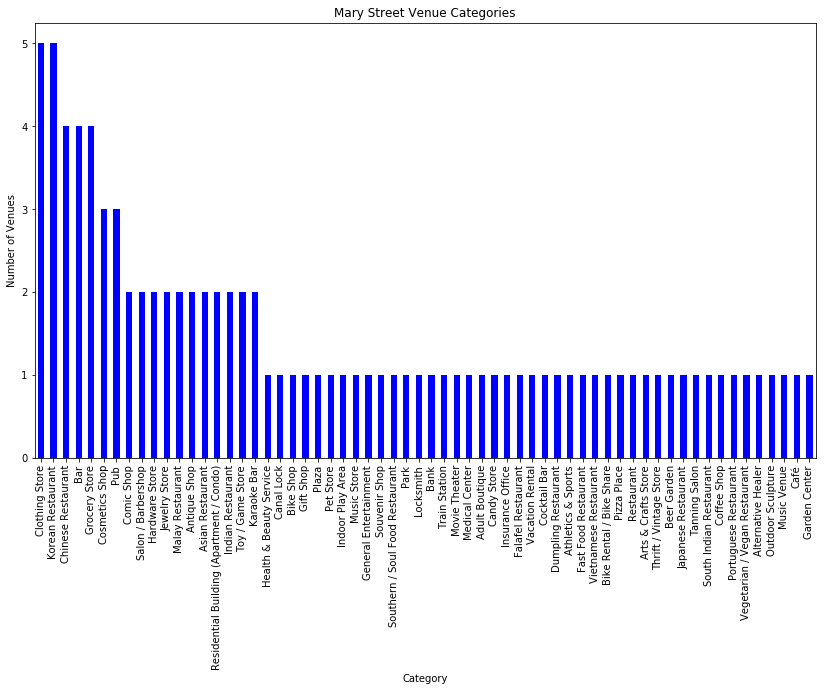

In [65]:
# Generate bar chart to show categories of venues near Mary Street
maryHist_df = maryFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Mary Street Venue Categories")
maryHist_df.set_xlabel("Category")
maryHist_df.set_ylabel("Number of Venues")

In [66]:
# create the API request URL to serach for venues near Sir John Rogersons Quay
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    roglatitude,
    roglongitude,
    radius,
    LIMIT)
rogresults = requests.get(url).json() 
rogresults

{'meta': {'code': 200, 'requestId': '5e3db410e826ac001ba7a6f5'},
 'response': {'venues': [{'id': '4d77d253a7e6b1f74e9a2bdf',
    'name': 'Matheson',
    'location': {'address': "70 Sir John Rogerson's Quay",
     'lat': 53.34528671612497,
     'lng': -6.233475208282471,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.34528671612497,
       'lng': -6.233475208282471}],
     'distance': 69,
     'postalCode': '2',
     'cc': 'IE',
     'city': 'Dublin',
     'state': 'Dublin City',
     'country': 'Ireland',
     'formattedAddress': ["70 Sir John Rogerson's Quay",
      'Dublin',
      'Dublin City',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d124941735',
      'name': 'Office',
      'pluralName': 'Offices',
      'shortName': 'Office',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581102212',
    'hasPerk': False},
   {'id': '5dbd77935dec290008c

In [67]:
# assign relevant part of JSON to Sir John Rogersons Quay venues
rogvenues = rogresults['response']['venues']

# tranform venues into a dataframe
rog_df = json_normalize(rogvenues)
rog_df.head()

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d124941735', 'name': 'O...    False   
1  [{'id': '4bf58dd8d48988d12d951735', 'name': 'B...    False   
2                                                 []    False   
3  [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...    False   
4  [{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...    False   

                         id             location.address location.cc  \
0  4d77d253a7e6b1f74e9a2bdf  70 Sir John Rogerson's Quay          IE   
1  5dbd77935dec290008c47e3b                          NaN          IE   
2  4b1fe4c3f964a5205f2a24e3          John Rogersons Quay          IE   
3  4bed253e9868a593b1f35c46                          NaN          IE   
4  5d908c2cf180cd0008de4250                          NaN          IE   

  location.city location.country location.crossStreet  location.distance  \
0        Dublin          Ireland                  NaN                 69   
1        Dublin          Ireland                  NaN                 88   
2        Dublin          Ireland                  NaN                 34   
3        Dublin          Ireland                  NaN                 54   
4        Dublin          Ireland                  NaN                 84   

                           location.formattedAddress  \
0  [70 Sir John Rogerson's Quay, Dublin, Dublin C...   
1                     [Dublin, Dublin City, Ireland]   
2  [John Rogersons Quay, Dublin, Dublin City, Ire...   
3                     [Dublin, Dublin City, Ireland]   
4                                  [Dublin, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.34528671612497...     53.345287   
1  [{'label': 'display', 'lat': 53.345954, 'lng':...     53.345954   
2  [{'label': 'display', 'lat': 53.34563645739624...     53.345636   
3  [{'label': 'display', 'lat': 53.34543777375258...     53.345438   
4  [{'label': 'display', 'lat': 53.345836, 'lng':...     53.345836   

   location.lng location.neighborhood location.postalCode location.state  \
0     -6.233475                   NaN                   2    Dublin City   
1     -6.235543                   NaN            DUBLIN 2    Dublin City   
2     -6.234818                   NaN                 NaN    Dublin City   
3     -6.233580                   NaN            Dublin 8    Dublin City   
4     -6.235529                   NaN            DUBLIN 2            NaN   

             name    referralId  
0        Matheson  v-1581102212  
1    ARA Libertad  v-1581102212  
2  MOP Solicitors  v-1581102212  
3       Café Sora  v-1581102212  
4         Gaswork  v-1581102212

In [68]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in rog_df.columns if col.startswith('location.')] + ['id']
rog_df_filtered = rog_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
rog_df_filtered['categories'] = rog_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
rog_df_filtered.columns = [column.split('.')[-1] for column in rog_df_filtered.columns]

rog_df_filtered.head(10)

name         categories  \
0        Matheson             Office   
1    ARA Libertad      Boat or Ferry   
2  MOP Solicitors               None   
3       Café Sora               Café   
4         Gaswork  Outdoor Sculpture   
5             FMB             Office   
6   Nave Vespucci      Boat or Ferry   
7  The Bottle Boy          Gastropub   
8           Fresh      Grocery Store   
9      The Mayson                Pub   

                                             address  cc    city  country  \
0                        70 Sir John Rogerson's Quay  IE  Dublin  Ireland   
1                                                NaN  IE  Dublin  Ireland   
2                                John Rogersons Quay  IE  Dublin  Ireland   
3                                                NaN  IE  Dublin  Ireland   
4                                                NaN  IE  Dublin  Ireland   
5                        Sir John Rogerson's Quay 56  IE  Dublin  Ireland   
6                                                NaN  IE     NaN  Ireland   
7                                 North Wall Quay 82  IE  Dublin  Ireland   
8  Capital Dock, units 4&5 Stevens walk, Sir John...  IE  Dublin  Ireland   
9                                 North Wall Quay 82  IE  Dublin  Ireland   

  crossStreet  distance                                   formattedAddress  \
0         NaN        69  [70 Sir John Rogerson's Quay, Dublin, Dublin C...   
1         NaN        88                     [Dublin, Dublin City, Ireland]   
2         NaN        34  [John Rogersons Quay, Dublin, Dublin City, Ire...   
3         NaN        54                     [Dublin, Dublin City, Ireland]   
4         NaN        84                                  [Dublin, Ireland]   
5         NaN        66  [Sir John Rogerson's Quay 56, Dublin, Dublin C...   
6         NaN        38                                          [Ireland]   
7  North Dock       202  [North Wall Quay 82 (North Dock), Dublin, Irel...   
8         NaN       149  [Capital Dock, units 4&5 Stevens walk, Sir Joh...   
9         NaN       200              [North Wall Quay 82, Dublin, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.34528671612497...  53.345287 -6.233475   
1  [{'label': 'display', 'lat': 53.345954, 'lng':...  53.345954 -6.235543   
2  [{'label': 'display', 'lat': 53.34563645739624...  53.345636 -6.234818   
3  [{'label': 'display', 'lat': 53.34543777375258...  53.345438 -6.233580   
4  [{'label': 'display', 'lat': 53.345836, 'lng':...  53.345836 -6.235529   
5  [{'label': 'display', 'lat': 53.34563258586094...  53.345633 -6.235299   
6  [{'label': 'display', 'lat': 53.34594679736732...  53.345947 -6.234637   
7  [{'label': 'display', 'lat': 53.347164, 'lng':...  53.347164 -6.232548   
8  [{'label': 'display', 'lat': 53.34523, 'lng': ...  53.345230 -6.232172   
9  [{'label': 'display', 'lat': 53.347136, 'lng':...  53.347136 -6.232531   

            neighborhood postalCode        state                        id  
0                    NaN          2  Dublin City  4d77d253a7e6b1f74e9a2bdf  
1                    NaN   DUBLIN 2  Dublin City  5dbd77935dec290008c47e3b  
2                    NaN        NaN  Dublin City  4b1fe4c3f964a5205f2a24e3  
3                    NaN   Dublin 8  Dublin City  4bed253e9868a593b1f35c46  
4                    NaN   DUBLIN 2          NaN  5d908c2cf180cd0008de4250  
5                    NaN          2  Dublin City  4f216cc7e4b0b5801b90a9e5  
6                    NaN        NaN          NaN  5038ea79e4b0b68ee4526b51  
7       North Inner City   D01 HC94          NaN  5e18dc91266cbc00084ca93a  
8  South-East Inner City          2          NaN  5e25b4a1e04f4900071c1638  
9                    NaN   DUBLIN 1          NaN  5dfd118a3d38a70008f243ce

In [69]:
# Remove unnecessary columns to generate final Temple Bar venues listings dataframe
rogFinal_df = rog_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
rogFinal_df

name  \
0                                  Matheson   
1                              ARA Libertad   
2                            MOP Solicitors   
3                                 Café Sora   
4                                   Gaswork   
5                                       FMB   
6                             Nave Vespucci   
7                            The Bottle Boy   
8                                     Fresh   
9                                The Mayson   
10                              Mackenzie’s   
11                         Classic Hits 4FM   
12                    Barque Eagle Tallship   
13                                   Indeed   
14                             barque eagle   
15                               Herbstreet   
16                        State Street Bank   
17  Spaces - Dublin, Spaces South Docklands   
18                              Tripadvisor   
19                       Accenture The Dock   
20               Buque Escuela Cuautçhtemoc   
21                               Pause Cafe   
22                   DublinBikes Station 66   
23                       L.E Samuel Beckett   
24                            Airbnb Dublin   
25                              J.P. Morgan   
26                           LogMeIn Dublin   
27                             Ancestry.com   
28                          Weber Shandwick   
29                              H10 Premium   
..                                      ...   
43                  hanover warf apartments   
44                               Park House   
45                                       63   
46                            Shannons Cafe   
47                       Vallence & McGrath   
48                            S. S. Artemis   
49                                    DAQRI   
50                             فندق السعادة   
51                           Jon Jon Museum   
52                        Kings Of Concrete   
53                                 Calimero   
54              Fitzwilliam Business Centre   
55                            Longboat Quay   
56                           MoneyMate Ltd.   
57                          The Place To Be   
58                                The Place   
59                  412 Longboat Quay north   
60                Urban Retreat Art Gallery   
61                   DublinBikes Station 90   
62                     Buque Escuela Guayas   
63       Patrick Lane & Company Accountants   
64                Dublin's Sunshine 106.8FM   
65                        Select Strategies   
66                            Game On Media   
67                              Informatica   
68                               Latin Hall   
69                      AIB Capital Markets   
70                              Informatica   
71                           Ashville Media   
72                                     Mops   

                                  categories  \
0                                     Office   
1                              Boat or Ferry   
2                                       None   
3                                       Café   
4                          Outdoor Sculpture   
5                                     Office   
6                              Boat or Ferry   
7                                  Gastropub   
8                              Grocery Store   
9                                        Pub   
10                Modern European Restaurant   
11                     Performing Arts Venue   
12                             Boat or Ferry   
13                                    Office   
14                             Boat or Ferry   
15                            Breakfast Spot   
16                                  Building   
17                          Business Service   
18                              Tech Startup   
19                                    Office   
20                             Boat or Ferry   
21                                      Café   
22                  

Text(0, 0.5, 'Number of Venues')

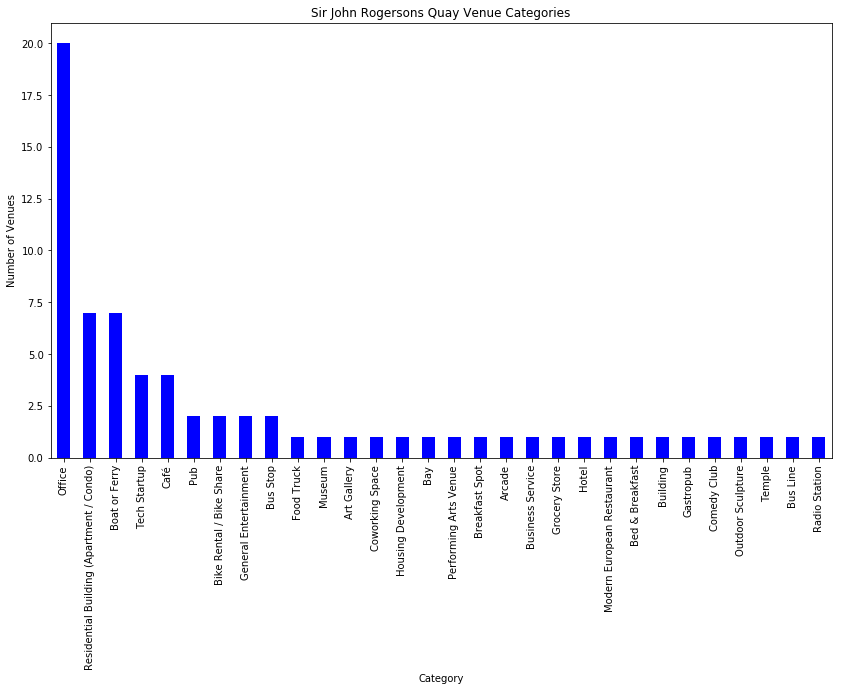

In [70]:
# Generate bar chart to show categories of venues near Sir John Rogerson's Quay
rogHist_df = rogFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Sir John Rogersons Quay Venue Categories")
rogHist_df.set_xlabel("Category")
rogHist_df.set_ylabel("Number of Venues")

In [71]:
# create the API request URL to search for venues in Rathmines
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    rathlatitude,
    rathlongitude,
    radius,
    LIMIT)
rathresults = requests.get(url).json() 
rathresults

{'meta': {'code': 200, 'requestId': '5e3db3fb1835dd001b2b8984'},
 'response': {'venues': [{'id': '5d3ca8dae5486f0008013e87',
    'name': 'Uno',
    'location': {'address': 'Rathmines',
     'lat': 53.32654,
     'lng': -6.264989,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.32654,
       'lng': -6.264989}],
     'distance': 9,
     'cc': 'IE',
     'city': 'Dublin',
     'country': 'Ireland',
     'formattedAddress': ['Rathmines', 'Dublin', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d1ca941735',
      'name': 'Pizza Place',
      'pluralName': 'Pizza Places',
      'shortName': 'Pizza',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581102221',
    'hasPerk': False},
   {'id': '5c7be3b0b9a5a8002cf2801d',
    'name': 'Hillbilly’s',
    'location': {'lat': 53.326484,
     'lng': -6.264952,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.326484

In [72]:
# assign relevant part of JSON to Rathmines venues
rathvenues = rathresults['response']['venues']

# tranform venues into a dataframe
rath_df = json_normalize(rathvenues)
rath_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
1  [{'id': '4bf58dd8d48988d16e941735', 'name': 'F...    False   
2  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
3  [{'id': '4bf58dd8d48988d118951735', 'name': 'G...    False   
4  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
5  [{'id': '4bf58dd8d48988d102941735', 'name': 'Y...    False   
6  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
7  [{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...    False   
8  [{'id': '4d1cf8421a97d635ce361c31', 'name': 'T...    False   
9  [{'id': '4d1cf8421a97d635ce361c31', 'name': 'T...    False   

                         id                     location.address location.cc  \
0  5d3ca8dae5486f0008013e87                            Rathmines          IE   
1  5c7be3b0b9a5a8002cf2801d                                  NaN          IE   
2  4bd0e077046076b03df07071           88-90 Lower Rathmines Road          IE   
3  4b7aca43f964a520e73c2fe3    101 Lower Rathmines Rd, Rathmines          IE   
4  5391f4fd498e1d03a72c5974                     Rathmines Rd Lwr          IE   
5  4c7be841794e224bc9ac6c28  St Mary's College, Lwr Rathmines Rd          IE   
6  53566061498e03ae386c8305                     Rathmines Rd Lwr          IE   
7  560bea21498e477634a094e4                                  NaN          IE   
8  4f2c09f2e4b0c0809d810fb6                  96 Rathmines Rd Lwr          IE   
9  5acd07fd396de024016dd16c                                  NaN          IE   

  location.city location.country location.crossStreet  location.distance  \
0        Dublin          Ireland                  NaN                  9   
1        Dublin          Ireland                  NaN                  7   
2        Dublin          Ireland                  NaN                 21   
3        Dublin          Ireland                  NaN                 22   
4        Dublin          Ireland                  NaN                 39   
5        Dublin          Ireland                  NaN                181   
6        Dublin          Ireland                  NaN                 24   
7           NaN          Ireland                  NaN                 28   
8        Dublin          Ireland                  NaN                 23   
9        Dublin          Ireland                  NaN                 35   

                           location.formattedAddress  \
0                       [Rathmines, Dublin, Ireland]   
1                                  [Dublin, Ireland]   
2  [88-90 Lower Rathmines Road, Dublin, Dublin Ci...   
3  [101 Lower Rathmines Rd, Rathmines, Dublin, Du...   
4   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
5  [St Mary's College, Lwr Rathmines Rd, Dublin, ...   
6   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
7                                          [Ireland]   
8  [96 Rathmines Rd Lwr, Dublin, Dublin City, Ire...   
9                                  [Dublin, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.32654, 'lng': ...     53.326540   
1  [{'label': 'display', 'lat': 53.326484, 'lng':...     53.326484   
2  [{'label': 'display', 'lat': 53.32668836627091...     53.326688   
3  [{'label': 'display', 'lat': 53.326711, 'lng':...     53.326711   
4  [{'label': 'display', 'lat': 53.32687089926742...     53.326871   
5  [{'label': 'display', 'lat': 53.32729863437836...     53.327299   
6  [{'label': 'display', 'lat': 53.3263017841516,...     53.326302   
7  [{'label': 'display', 'lat': 53.32639061496717...     53.326391   
8  [{'label': 'display', 'lat': 53.32672836820805...     53.326728   
9  [{'label': 'display', 'lat': 53.326836, 'lng':...     53.326836   

   location.lng location.postalCode location.state  \
0     -6.264989                 NaN            NaN   
1     -6.264952            DUBLIN 6            NaN   
2     -6.264708            D06 H7X3    Dublin City   
3   

In [73]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in rath_df.columns if col.startswith('location.')] + ['id']
rath_df_filtered = rath_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
rath_df_filtered['categories'] = rath_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
rath_df_filtered.columns = [column.split('.')[-1] for column in rath_df_filtered.columns]

rath_df_filtered.head(10)

name            categories  \
0                           Uno           Pizza Place   
1                   Hillbilly’s  Fast Food Restaurant   
2                Domino's Pizza           Pizza Place   
3             Oriental Emporium         Grocery Store   
4                     Blackbird                   Pub   
5                Yoga Rathmines           Yoga Studio   
6        The Orange Tree Bakery        Sandwich Place   
7  Grace's Famous Fried Chicken   Fried Chicken Joint   
8                   Muscle Shop         Tanning Salon   
9                   Tanning Hub         Tanning Salon   

                               address  cc    city  country crossStreet  \
0                            Rathmines  IE  Dublin  Ireland         NaN   
1                                  NaN  IE  Dublin  Ireland         NaN   
2           88-90 Lower Rathmines Road  IE  Dublin  Ireland         NaN   
3    101 Lower Rathmines Rd, Rathmines  IE  Dublin  Ireland         NaN   
4                     Rathmines Rd Lwr  IE  Dublin  Ireland         NaN   
5  St Mary's College, Lwr Rathmines Rd  IE  Dublin  Ireland         NaN   
6                     Rathmines Rd Lwr  IE  Dublin  Ireland         NaN   
7                                  NaN  IE     NaN  Ireland         NaN   
8                  96 Rathmines Rd Lwr  IE  Dublin  Ireland         NaN   
9                                  NaN  IE  Dublin  Ireland         NaN   

   distance                                   formattedAddress  \
0         9                       [Rathmines, Dublin, Ireland]   
1         7                                  [Dublin, Ireland]   
2        21  [88-90 Lower Rathmines Road, Dublin, Dublin Ci...   
3        22  [101 Lower Rathmines Rd, Rathmines, Dublin, Du...   
4        39   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
5       181  [St Mary's College, Lwr Rathmines Rd, Dublin, ...   
6        24   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
7        28                                          [Ireland]   
8        23  [96 Rathmines Rd Lwr, Dublin, Dublin City, Ire...   
9        35                                  [Dublin, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.32654, 'lng': ...  53.326540 -6.264989   
1  [{'label': 'display', 'lat': 53.326484, 'lng':...  53.326484 -6.264952   
2  [{'label': 'display', 'lat': 53.32668836627091...  53.326688 -6.264708   
3  [{'label': 'display', 'lat': 53.326711, 'lng':...  53.326711 -6.264961   
4  [{'label': 'display', 'lat': 53.32687089926742...  53.326871 -6.264804   
5  [{'label': 'display', 'lat': 53.32729863437836...  53.327299 -6.267251   
6  [{'label': 'display', 'lat': 53.3263017841516,...  53.326302 -6.264924   
7  [{'label': 'display', 'lat': 53.32639061496717...  53.326391 -6.265219   
8  [{'label': 'display', 'lat': 53.32672836820805...  53.326728 -6.264857   
9  [{'label': 'display', 'lat': 53.326836, 'lng':...  53.326836 -6.264802   

  postalCode        state                        id  
0        NaN          NaN  5d3ca8dae5486f0008013e87  
1   DUBLIN 6          NaN  5c7be3b0b9a5a8002cf2801d  
2   D06 H7X3  Dublin City  4bd0e077046076b03df07071  
3          6  Dublin City  4b7aca43f964a520e73c2fe3  
4          6  Dublin City  5391f4fd498e1d03a72c5974  
5          6  Dublin City  4c7be841794e224bc9ac6c28  
6          6  Dublin City  53566061498e03ae386c8305  
7        NaN          NaN  560bea21498e477634a094e4  
8          6  Dublin City  4f2c09f2e4b0c0809d810fb6  
9   DUBLIN 6          NaN  5acd07fd396de024016dd16c

In [74]:
# Remove unnecessary columns to generate final Rathmines venues listings dataframe
rathFinal_df = rath_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'postalCode', 'state'], axis=1).reset_index(drop=True)
rathFinal_df

name  \
0                                Uno   
1                        Hillbilly’s   
2                     Domino's Pizza   
3                  Oriental Emporium   
4                          Blackbird   
5                     Yoga Rathmines   
6             The Orange Tree Bakery   
7       Grace's Famous Fried Chicken   
8                        Muscle Shop   
9                        Tanning Hub   
10                 Canal View Dental   
11                            Subway   
12                       Camile Thai   
13                              Aldi   
14                           Chopped   
15  The Laundry and Drycleaning Shop   
16           Leinster Sports Complex   
17               Swan Leisure Centre   
18                     Farmer Browns   
19              Irish Cancer Society   
20                    Pavillion View   
21             Leinster Cricket Club   
22                The Balance Centre   
23                 Cawley Nea / TBWA   
24                      Hit The Spot   
25                              Lidl   
26                        New Empire   
27                       Sandy Nails   
28                         Thinkbike   
29         Church of Mary Immaculate   
..                               ...   
70                Rathmines Pharmacy   
71                 The 3rd Policeman   
72                       Banana Tree   
73                       The Jockeys   
74                Looce's Irish Camp   
75              Shirley's Laundrette   
76                      MART Project   
77                  Karate Rathmines   
78                       Hawker Cafe   
79                 Prostyle Nail-Bar   
80                         Porta-Via   
81                         Manifesto   
82                  Rathmines Barber   
83           Dublin Bus Stop No 1071   
84                      Tynan Pianos   
85                           Clegg's   
86                             Toast   
87        Holy Trinity Church Office   
88                  Elvis Guesthouse   
89            Jacqui's Beauty Treats   
90              Pololith Fruit & Veg   
91                  The Coffee House   
92       Rathmines Grill & Take Away   
93                       Young Works   
94                Euro Giant Express   
95                     DIT Rathmines   
96                               4pm   
97                 Mountpleasant Inn   
98            St. Mary's Boys School   
99               Guama House Ireland   

                                  categories  \
0                                Pizza Place   
1                       Fast Food Restaurant   
2                                Pizza Place   
3                              Grocery Store   
4                                        Pub   
5                                Yoga Studio   
6                             Sandwich Place   
7                        Fried Chicken Joint   
8                              Tanning Salon   
9                              Tanning Salon   
10                          Dentist's Office   
11                            Sandwich Place   
12                           Thai Restaurant   
13                               Supermarket   
14                               Salad Place   
15                           Laundry Service   
16                        Athletics & Sports   
17                      Gym / Fitness Center   
18                                Restaurant   
19                    Thrift / Vintage Store   
20  Residential Building (Apartment / Condo)   
21                            Cricket Ground   
22                        Physical Therapist   
23                                    Office   
24                      Fast Food Restaurant   
25                               Supermarket   
26                        Chinese Restaurant   
27                                Nail Salon   
28                                 Bike Shop   
29                                    Church   
..                                       ...   
70             

Text(0, 0.5, 'Number of Venues')

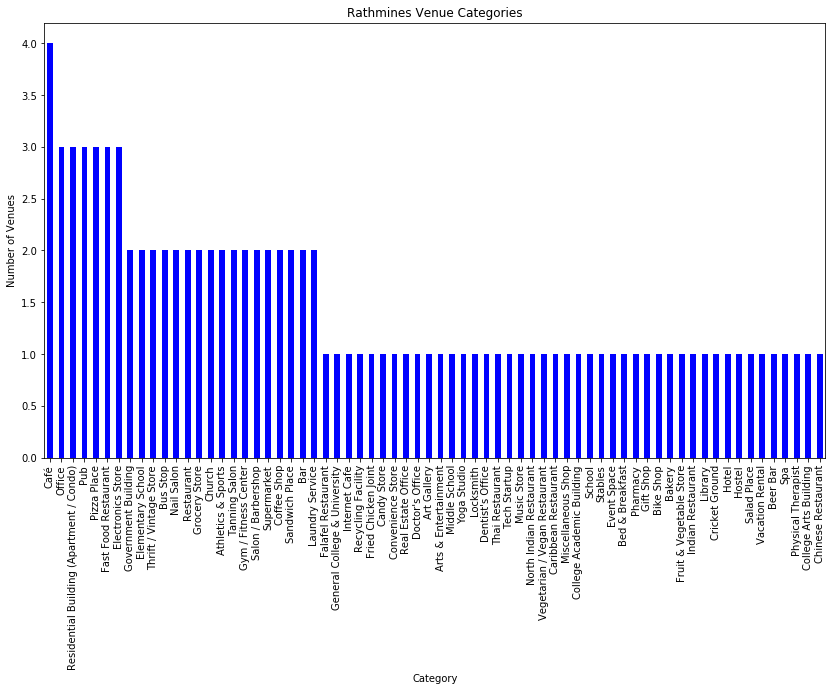

In [75]:
# Generate bar chart to show categories of venues in Rathmines
rathHist_df = rathFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Rathmines Venue Categories")
rathHist_df.set_xlabel("Category")
rathHist_df.set_ylabel("Number of Venues")

In [76]:
# create the API request URL to serach for venues near Kilmainham
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    killatitude,
    killongitude,
    radius,
    LIMIT)
kilresults = requests.get(url).json() 
kilresults

{'meta': {'code': 200, 'requestId': '5e3db4580cc1fd001bd39845'},
 'response': {'venues': [{'id': '5d4976d26018fe0008fa896c',
    'name': 'Circle K',
    'location': {'address': 'South Circular Road',
     'lat': 53.341541,
     'lng': -6.308013,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.341541,
       'lng': -6.308013}],
     'distance': 73,
     'postalCode': 'DUBLIN 8',
     'cc': 'IE',
     'city': 'Dublin',
     'country': 'Ireland',
     'formattedAddress': ['South Circular Road', 'Dublin', 'Ireland']},
    'categories': [{'id': '4d954b0ea243a5684a65b473',
      'name': 'Convenience Store',
      'pluralName': 'Convenience Stores',
      'shortName': 'Convenience Store',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/conveniencestore_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581102227',
    'hasPerk': False},
   {'id': '5999726accad6b5a979d6c90',
    'name': 'Parcel Motel',
    'location': {'address': 'T

In [77]:
# assign relevant part of JSON to Kilmainham venues
kilvenues = kilresults['response']['venues']

# tranform venues into a dataframe
kil_df = json_normalize(kilvenues)
kil_df.head(10)

categories  hasPerk  \
0  [{'id': '4d954b0ea243a5684a65b473', 'name': 'C...    False   
1  [{'id': '4bf58dd8d48988d172941735', 'name': 'P...    False   
2  [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...    False   
3  [{'id': '4deefb944765f83613cdba6e', 'name': 'H...    False   
4  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
5  [{'id': '4d954b0ea243a5684a65b473', 'name': 'C...    False   
6  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...    False   
7  [{'id': '4bf58dd8d48988d113951735', 'name': 'G...    False   
8  [{'id': '4d954b0ea243a5684a65b473', 'name': 'C...    False   
9  [{'id': '4bf58dd8d48988d117941735', 'name': 'B...    False   

                         id                       location.address  \
0  5d4976d26018fe0008fa896c                    South Circular Road   
1  5999726accad6b5a979d6c90                   Topaz, S Circular Rd   
2  56800910498ec4c64e769907                      740 S Circular Rd   
3  4ade0f15f964a520117121e3             2 Inchicore Rd, Kilmainham   
4  4c8a5b96770fb60cefc4d1c3          645 S Circular Rd, Kilmainham   
5  4b698571f964a520b3a52be3  625-627 South Circular Rd, Kilmainham   
6  4bcf619d0ffdce72546ab2c0              S Circular Rd, Kilmainham   
7  4bc5b8dc6a3e9c74a42ef648              S Circular Rd, Kilmainham   
8  4ef8b5ea93ad7cf2eb790a2a                    South Circular Road   
9  4e0a29e47d8b2a01806d79dc                                    NaN   

  location.cc location.city location.country location.crossStreet  \
0          IE        Dublin          Ireland                  NaN   
1          IE        Dublin          Ireland                  NaN   
2          IE        Dublin          Ireland                  NaN   
3          IE        Dublin          Ireland                  NaN   
4          IE        Dublin          Ireland                  NaN   
5          IE        Dublin          Ireland                  NaN   
6          IE        Dublin          Ireland                  NaN   
7          IE        Dublin          Ireland                  NaN   
8          IE        Dublin          Ireland           Emmet Road   
9          IE        Dublin          Ireland                  NaN   

   location.distance                          location.formattedAddress  \
0                 73             [South Circular Road, Dublin, Ireland]   
1                 68            [Topaz, S Circular Rd, Dublin, Ireland]   
2                 43  [740 S Circular Rd, Dublin, Dublin City, Ireland]   
3                119  [2 Inchicore Rd, Kilmainham, Dublin, Dublin Ci...   
4                 48  [645 S Circular Rd, Kilmainham, Dublin, Dublin...   
5                124  [625-627 South Circular Rd, Kilmainham, Dublin...   
6                154  [S Circular Rd, Kilmainham, Dublin, Dublin Cit...   
7                 48  [S Circular Rd, Kilmainham, Dublin, Dublin Cit...   
8                232  [South Circular Road (Emmet Road), Dublin, Dub...   
9                 55                     [Dublin, Dublin City, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.341541, 'lng':...     53.341541   
1  [{'label': 'display', 'lat': 53.341497, 'lng':...     53.341497   
2  [{'label': 'display', 'lat': 53.34071712654384...     53.340717   
3  [{'label': 'display', 'lat': 53.34184914976544...     53.341849   
4  [{'label': 'display', 'lat': 53.34077693603113...     53.340777   
5  [{'label': 'display', 'lat': 53.33994747286348...     53.339947   
6  [{'label': 'display', 'lat': 53.34231137016567...     53.342311   
7  [{'label': 'display', 'lat': 53.34127119040788...     53.341271   
8  [{'label': 'display', 'lat': 53.34284484857122...     53.342845   
9  [{'label': 'display', 'lat': 53.341065, 'lng':...     53.341065   

   location.lng location.neighborhood location.postalCode location.state  \
0     -6.308013                   NaN            DUBLIN 8            NaN   
1     -6.307989                   NaN         

In [78]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in kil_df.columns if col.startswith('location.')] + ['id']
kil_df_filtered = kil_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
kil_df_filtered['categories'] = kil_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
kil_df_filtered.columns = [column.split('.')[-1] for column in kil_df_filtered.columns]

kil_df_filtered.head(10)

name         categories                                address  \
0         Circle K  Convenience Store                    South Circular Road   
1     Parcel Motel        Post Office                   Topaz, S Circular Rd   
2           Union8         Restaurant                      740 S Circular Rd   
3  Kilmainham Gaol      Historic Site             2 Inchicore Rd, Kilmainham   
4  Four Star Pizza        Pizza Place          645 S Circular Rd, Kilmainham   
5             SPAR  Convenience Store  625-627 South Circular Rd, Kilmainham   
6           Hilton              Hotel              S Circular Rd, Kilmainham   
7            Topaz        Gas Station              S Circular Rd, Kilmainham   
8         Eurospar  Convenience Store                    South Circular Road   
9      Lady's Lane        Beer Garden                                    NaN   

   cc    city  country crossStreet  distance  \
0  IE  Dublin  Ireland         NaN        73   
1  IE  Dublin  Ireland         NaN        68   
2  IE  Dublin  Ireland         NaN        43   
3  IE  Dublin  Ireland         NaN       119   
4  IE  Dublin  Ireland         NaN        48   
5  IE  Dublin  Ireland         NaN       124   
6  IE  Dublin  Ireland         NaN       154   
7  IE  Dublin  Ireland         NaN        48   
8  IE  Dublin  Ireland  Emmet Road       232   
9  IE  Dublin  Ireland         NaN        55   

                                    formattedAddress  \
0             [South Circular Road, Dublin, Ireland]   
1            [Topaz, S Circular Rd, Dublin, Ireland]   
2  [740 S Circular Rd, Dublin, Dublin City, Ireland]   
3  [2 Inchicore Rd, Kilmainham, Dublin, Dublin Ci...   
4  [645 S Circular Rd, Kilmainham, Dublin, Dublin...   
5  [625-627 South Circular Rd, Kilmainham, Dublin...   
6  [S Circular Rd, Kilmainham, Dublin, Dublin Cit...   
7  [S Circular Rd, Kilmainham, Dublin, Dublin Cit...   
8  [South Circular Road (Emmet Road), Dublin, Dub...   
9                     [Dublin, Dublin City, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.341541, 'lng':...  53.341541 -6.308013   
1  [{'label': 'display', 'lat': 53.341497, 'lng':...  53.341497 -6.307989   
2  [{'label': 'display', 'lat': 53.34071712654384...  53.340717 -6.307631   
3  [{'label': 'display', 'lat': 53.34184914976544...  53.341849 -6.308478   
4  [{'label': 'display', 'lat': 53.34077693603113...  53.340777 -6.307854   
5  [{'label': 'display', 'lat': 53.33994747286348...  53.339947 -6.307652   
6  [{'label': 'display', 'lat': 53.34231137016567...  53.342311 -6.308232   
7  [{'label': 'display', 'lat': 53.34127119040788...  53.341271 -6.307902   
8  [{'label': 'display', 'lat': 53.34284484857122...  53.342845 -6.309064   
9  [{'label': 'display', 'lat': 53.341065, 'lng':...  53.341065 -6.306446   

  neighborhood postalCode        state                        id  
0          NaN   DUBLIN 8          NaN  5d4976d26018fe0008fa896c  
1          NaN          8          NaN  5999726accad6b5a979d6c90  
2          NaN          8  Dublin City  56800910498ec4c64e769907  
3          NaN          8  Dublin City  4ade0f15f964a520117121e3  
4          NaN          8  Dublin City  4c8a5b96770fb60cefc4d1c3  
5          NaN          8  Dublin City  4b698571f964a520b3a52be3  
6          NaN          8  Dublin City  4bcf619d0ffdce72546ab2c0  
7          NaN          8  Dublin City  4bc5b8dc6a3e9c74a42ef648  
8          NaN          8  Dublin City  4ef8b5ea93ad7cf2eb790a2a  
9          NaN        NaN  Dublin City  4e0a29e47d8b2a01806d79dc

In [79]:
# Remove unnecessary columns to generate final Kilmainham venues listings dataframe
kilFinal_df = kil_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'postalCode', 'state'], axis=1).reset_index(drop=True)
kilFinal_df

name                                categories  \
0                      Circle K                         Convenience Store   
1                  Parcel Motel                               Post Office   
2                        Union8                                Restaurant   
3               Kilmainham Gaol                             Historic Site   
4               Four Star Pizza                               Pizza Place   
5                          SPAR                         Convenience Store   
6                        Hilton                                     Hotel   
7                         Topaz                               Gas Station   
8                      Eurospar                         Convenience Store   
9                   Lady's Lane                               Beer Garden   
10             The Patriots Inn                                       Pub   
11     Kilmainham Garda Station                            Police Station   
12                La Dolce Vita                        Italian Restaurant   
13      Prison Chill Mhaigneann                             Historic Site   
14                 Cutting Edge                        Salon / Barbershop   
15                     Insomnia                               Coffee Shop   
16                      78a Bus                                      None   
17                Zinc Hair Spa                        Salon / Barbershop   
18    New Land Chinese Takeaway                        Chinese Restaurant   
19                   Kleen Well                           Laundry Service   
20                 Bully's Acre                                  Cemetery   
21           Brambles Deli Cafe                                      Café   
22            St James' Route 2                                      None   
23         Broyage Bar & Bistro                                 Hotel Bar   
24          Cinnamon Restaurant                                Restaurant   
25            Inchicore Library                                   Library   
26       DublinBikes Station 83                  Bike Rental / Bike Share   
27      Dublin Bus Stop No 1993                                  Bus Stop   
28      Dublin Bus Stop No 1992                                  Bus Line   
29               St James' Wood  Residential Building (Apartment / Condo)   
..                          ...                                       ...   
70       DublinBikes Station 96                  Bike Rental / Bike Share   
71      Inchicore College of FE                     College Arts Building   
72                  Salon Rouge                        Salon / Barbershop   
73   Ennio Morricone At The RHK                                 Rock Club   
74                Siptu College                         College Classroom   
75                         Mace                             Grocery Store   
76                          67x                                      None   
77                          DPL                                      None   
78                         Klas                                    Office   
79            63 Camac Crescent  Residential Building (Apartment / Condo)   
80               La Boulangerie                                    Bakery   
81  Palmerstown Service Station                               Gas Station   
82       Kilmainham Post Office                               Post Office   
83           The Laundry Basket                           Laundry Service   
84  bridgewater Business centre                                    Office   
85         Carey And Keane Vets                                      None   
86          700 St James's Wood  Residential Building (Apartment / Condo)   
87      Dublin Bus Stop No 1945                                  Bus Line   
88                    The Steps  Residential Building (Apartment / Condo)   
89                 Europrinters                           Coworking Space   
90     Dublin Providers

Text(0, 0.5, 'Number of Venues')

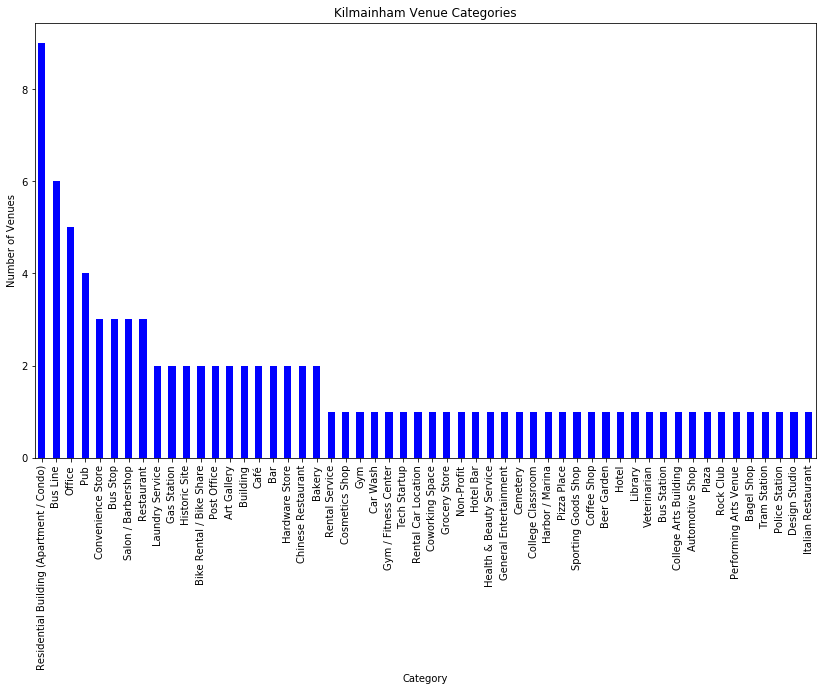

In [80]:
# Generate bar chart to show categories of venues in Kilmainham
kilHist_df = kilFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Kilmainham Venue Categories")
kilHist_df.set_xlabel("Category")
kilHist_df.set_ylabel("Number of Venues")

# Cork Geospatial Analysis

In [81]:
# Use geopy library to get geographical co-ordinates for Cork
address = 'Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
corlatitude = location.latitude
corlongitude = location.longitude
print('The geograpical coordinate of Cork are {}, {}.'.format(corlatitude, corlongitude))

The geograpical coordinate of Cork are 51.8979282, -8.4705806.


In [82]:
# Create folium map for Cork
cor_map = folium.Map(location=[corlatitude, corlongitude], zoom_start=12)
cor_map

In [83]:
# Add markers to the Cork map for each of the Airbnb Listings
for lat, long, ident, pname in zip(corListFinal_df['latitude'], corListFinal_df['longitude'], corListFinal_df['id'], corListFinal_df['name']):
    label = "{}".format(ident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(cor_map)
    
cor_map

As expected, the majority of listings appear to be clustered around the city centre.
However there appears to be a second cluster around the Douglas area and a third smaller cluster around the Blarney Area.
It would be interesting to see why Douglas and Blarney are popular despite not being in the city centre.

## Perform Kmeans Clustering on Cork Airbnb Listings

In [84]:
# Create new datframe with just id and latittude, longitude for Cork Airbnb Listing
corKclust_df=corListFinal_df.loc[:,['id','latitude','longitude']]
corKclust_df.head(10)

id  latitude  longitude
0   9548704  51.89126   -8.46324
1  13344373  51.88995   -8.47027
2  27196730  51.89633   -8.48618
3   3088179  51.89269   -8.47284
4  24804603  51.88932   -8.46825
5  38741027  51.89623   -8.47748
6  15388361  51.88914   -8.50054
7  36666968  51.86630   -8.46725
8  17311815  51.89624   -8.46968
9  19499792  51.89426   -8.49226

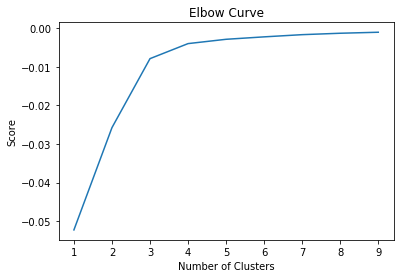

In [85]:
# Create Elbow curve to determine correct number of clusters
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = corKclust_df[['latitude']]
X_axis = corKclust_df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [86]:
# Perform kmeans clustering on Cork Airbnb and add to datframe
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(corKclust_df[corKclust_df.columns[1:3]]) # Compute k-means clustering.
corKclust_df['cluster_label'] = kmeans.fit_predict(corKclust_df[corKclust_df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(corKclust_df[corKclust_df.columns[1:3]]) # Labels of each point
corKclust_df.head(50)

id  latitude  longitude  cluster_label
0    9548704  51.89126   -8.46324              1
1   13344373  51.88995   -8.47027              1
2   27196730  51.89633   -8.48618              1
3    3088179  51.89269   -8.47284              1
4   24804603  51.88932   -8.46825              1
5   38741027  51.89623   -8.47748              1
6   15388361  51.88914   -8.50054              1
7   36666968  51.86630   -8.46725              0
8   17311815  51.89624   -8.46968              1
9   19499792  51.89426   -8.49226              1
10   3074863  51.89348   -8.47924              1
11  37032716  51.90095   -8.47636              1
12  13825973  51.86357   -8.44881              0
13  25348483  51.89049   -8.47042              1
14  26359097  51.89205   -8.47063              1
15  27382729  51.89202   -8.48265              1
16   2216069  51.87127   -8.45269              0
17  17354127  51.86813   -8.47917              1
18  17180728  51.89779   -8.48029              1
19  17236598  51.89718   -8.48200              1
20  33222836  51.89945   -8.47722              1
21  33775801  51.89143   -8.48332              1
22  34377208  51.89354   -8.47599              1
23  17214394  51.89632   -8.48329              1
24  23799104  51.89775   -8.47203              1
25  25278030  51.89723   -8.47845              1
26  31551232  51.86303   -8.44906              0
27  21922497  51.86572   -8.45076              0
28  19118811  51.86951   -8.44887              0
29  35089236  51.90332   -8.47117              1
30  33011926  51.90028   -8.46461              1
31  24280674  51.95008   -8.39776              2
32  32718143  51.90290   -8.46529              1
33  32380273  51.90207   -8.46415              1
34  35080220  51.90140   -8.46952              1
35  18058458  51.90469   -8.46023              1
36  25831254  51.90242   -8.46696              1
37  18805095  51.90530   -8.45914              1
38  35090988  51.90892   -8.47101              1
39  34377533  51.90565   -8.45174              1
40  18058734  51.90507   -8.45751              1
41  15077262  51.90407   -8.45269              1
42  29196565  51.93366   -8.39103              2
43  18649731  51.90464   -8.46915              1
44  35700639  51.90092   -8.46632              1
45  32631658  51.90194   -8.46336              1
46  23447934  51.91084   -8.43298              0
47  25271696  51.90078   -8.46927              1
48  30737220  51.90378   -8.45645              1
49  37032154  51.91310   -8.47583              1

In [88]:
# Visualize clusters on map of Cork
# create map

kclusters = 3

cormap_clusters = folium.Map(location=[corlatitude, corlongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, id, cluster in zip(corKclust_df['latitude'], corKclust_df['longitude'], corKclust_df['id'], corKclust_df['cluster_label']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cormap_clusters)
       
cormap_clusters

In [108]:
# Use geopy library to get geographical co-ordinates for Douglas, Cork
address = 'Douglas, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
douglatitude = location.latitude
douglongitude = location.longitude
print('The geograpical coordinate of Douglas, Cork are {}, {}.'.format(douglatitude, douglongitude))

The geograpical coordinate of Douglas, Cork are 51.8774785, -8.436061.


In [109]:
# Use geopy library to get geographical co-ordinates for Blarney, Cork
address = 'Blarney, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
blarlatitude = location.latitude
blarlongitude = location.longitude
print('The geograpical coordinate of Blarney, Cork are {}, {}.'.format(blarlatitude, blarlongitude))

The geograpical coordinate of Blarney, Cork are 51.9333535, -8.5666702.


## Use Foursquare API to explore venues in Cork City Centre, Douglas & Blarney

In [110]:
# Access Foursquare API

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [111]:
# Create radius of 500m and limit of 50 venues
radius = 500
LIMIT = 50

In [112]:
# create the API request URL to serach for venues in Cork City Centre
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    corlatitude,
    corlongitude,
    radius,
    LIMIT)
corccresults = requests.get(url).json() 
corccresults

{'meta': {'code': 200, 'requestId': '5e3b3c5ffb34b5001b0c1c1d'},
 'response': {'venues': [{'id': '4b76ca67f964a520555f2ee3',
    'name': 'Butlers Chocolate Café',
    'location': {'address': '30 Oliver Plunkett St',
     'lat': 51.89794991177399,
     'lng': -8.47071869776603,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.89794991177399,
       'lng': -8.47071869776603}],
     'distance': 9,
     'cc': 'IE',
     'city': 'Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['30 Oliver Plunkett St',
      'Cork',
      'Co Cork',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580940450',
    'hasPerk': False},
   {'id': '4c3dc1d015cb1b8d7b547cdc',
    'name': 'Ge

In [113]:
# assign relevant part of JSON to Cork City Centre venues
corccvenues = corccresults['response']['venues']

# tranform venues into a dataframe
corcc_df = json_normalize(corccvenues)
corcc_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...    False   
1  [{'id': '4bf58dd8d48988d172941735', 'name': 'P...    False   
2  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
3  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
4  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
5  [{'id': '4bf58dd8d48988d123941735', 'name': 'W...    False   
6  [{'id': '52f2ab2ebcbc57f1066b8b31', 'name': 'C...    False   
7  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
8  [{'id': '4bf58dd8d48988d10c951735', 'name': 'C...    False   
9  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...    False   

                         id        location.address location.cc location.city  \
0  4b76ca67f964a520555f2ee3   30 Oliver Plunkett St          IE          Cork   
1  4c3dc1d015cb1b8d7b547cdc      Oliver Plunkett St          IE          Cork   
2  4ba67a29f964a520745639e3         10 Winthrop St.          IE          Cork   
3  4c18f3e1fe5a76b0f5c90215             Winthrop St          IE          Cork   
4  4c02b5ed9a7920a10fd9ce79  108 Oliver Plunkett St          IE          Cork   
5  4f8f2f90e4b0db4703371588           7 Pembroke St          IE          Cork   
6  4c3dc1694bc9a5938d66d471       Oliver Plunket St          IE          Cork   
7  4bdf57a46198c9b68ce016ff             Pembroke St          IE          Cork   
8  4f4500e2e4b0f94a3639f927                     NaN          IE           NaN   
9  4b3c8f13f964a5201c8525e3              South Mall          IE          Cork   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                  9   
1          Ireland                  NaN                 13   
2          Ireland                  NaN                 28   
3          Ireland                  NaN                 16   
4          Ireland                  NaN                 10   
5          Ireland                  NaN                 53   
6          Ireland                  NaN                 14   
7          Ireland                  NaN                 24   
8          Ireland                  NaN                 72   
9          Ireland                  NaN                102   

                          location.formattedAddress  \
0   [30 Oliver Plunkett St, Cork, Co Cork, Ireland]   
1      [Oliver Plunkett St, Cork, Co Cork, Ireland]   
2         [10 Winthrop St., Cork, Co Cork, Ireland]   
3             [Winthrop St, Cork, Co Cork, Ireland]   
4  [108 Oliver Plunkett St, Cork, Co Cork, Ireland]   
5           [7 Pembroke St, Cork, Co Cork, Ireland]   
6       [Oliver Plunket St, Cork, Co Cork, Ireland]   
7             [Pembroke St, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9              [South Mall, Cork, Co Cork, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.89794991177399...     51.897950   
1  [{'label': 'display', 'lat': 51.89799719284036...     51.897997   
2  [{'label': 'display', 'lat': 51.89816962412247...     51.898170   
3  [{'label': 'display', 'lat': 51.89807847807349...     51.898078   
4  [{'label': 'display', 'lat': 51.8980037711242,...     51.898004   
5  [{'label': 'display', 'lat': 51.89763189993279...     51.897632   
6  [{'label': 'display', 'lat': 51.89805379322438...     51.898054   
7  [{'label': 'display', 'lat': 51.89789665636476...     51.897897   
8  [{'label': 'display', 'lat': 51.89796169582751...     51.897962   
9  [{'label': 'display', 'lat': 51.89708416132273...     51.897084   

   location.lng location.neighborhood location.postalCode location.state  \
0     -8.470719                   NaN                 NaN        Co Cork   
1     -8.470414                   NaN                 NaN        Co Cork   
2     -8.470457                   NaN                 NaN        Co Cork   
3     -8.470602                   NaN                 NaN        Co Co

In [114]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in corcc_df.columns if col.startswith('location.')] + ['id']
corcc_df_filtered = corcc_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
corcc_df_filtered['categories'] = corcc_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
corcc_df_filtered.columns = [column.split('.')[-1] for column in corcc_df_filtered.columns]

corcc_df_filtered.head(10)

name      categories  \
0               Butlers Chocolate Café     Coffee Shop   
1            General Post Office (GPO)     Post Office   
2                      The Long Valley             Pub   
3                O'Briens Sandwich Bar  Sandwich Place   
4                 Hibernian Bar (Hi B)             Pub   
5  Arthur Mayne Pharmacy & Wine Garden        Wine Bar   
6                             Leonidas  Chocolate Shop   
7                            Fast Al's     Pizza Place   
8               Hennessys Hair Suppies  Cosmetics Shop   
9                       Imperial Hotel           Hotel   

                  address  cc  city  country crossStreet  distance  \
0   30 Oliver Plunkett St  IE  Cork  Ireland         NaN         9   
1      Oliver Plunkett St  IE  Cork  Ireland         NaN        13   
2         10 Winthrop St.  IE  Cork  Ireland         NaN        28   
3             Winthrop St  IE  Cork  Ireland         NaN        16   
4  108 Oliver Plunkett St  IE  Cork  Ireland         NaN        10   
5           7 Pembroke St  IE  Cork  Ireland         NaN        53   
6       Oliver Plunket St  IE  Cork  Ireland         NaN        14   
7             Pembroke St  IE  Cork  Ireland         NaN        24   
8                     NaN  IE   NaN  Ireland         NaN        72   
9              South Mall  IE  Cork  Ireland         NaN       102   

                                   formattedAddress  \
0   [30 Oliver Plunkett St, Cork, Co Cork, Ireland]   
1      [Oliver Plunkett St, Cork, Co Cork, Ireland]   
2         [10 Winthrop St., Cork, Co Cork, Ireland]   
3             [Winthrop St, Cork, Co Cork, Ireland]   
4  [108 Oliver Plunkett St, Cork, Co Cork, Ireland]   
5           [7 Pembroke St, Cork, Co Cork, Ireland]   
6       [Oliver Plunket St, Cork, Co Cork, Ireland]   
7             [Pembroke St, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9              [South Mall, Cork, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.89794991177399...  51.897950 -8.470719   
1  [{'label': 'display', 'lat': 51.89799719284036...  51.897997 -8.470414   
2  [{'label': 'display', 'lat': 51.89816962412247...  51.898170 -8.470457   
3  [{'label': 'display', 'lat': 51.89807847807349...  51.898078 -8.470602   
4  [{'label': 'display', 'lat': 51.8980037711242,...  51.898004 -8.470491   
5  [{'label': 'display', 'lat': 51.89763189993279...  51.897632 -8.469974   
6  [{'label': 'display', 'lat': 51.89805379322438...  51.898054 -8.470607   
7  [{'label': 'display', 'lat': 51.89789665636476...  51.897897 -8.470222   
8  [{'label': 'display', 'lat': 51.89796169582751...  51.897962 -8.471635   
9  [{'label': 'display', 'lat': 51.89708416132273...  51.897084 -8.469992   

  neighborhood postalCode    state                        id  
0          NaN        NaN  Co Cork  4b76ca67f964a520555f2ee3  
1          NaN        NaN  Co Cork  4c3dc1d015cb1b8d7b547cdc  
2          NaN        NaN  Co Cork  4ba67a29f964a520745639e3  
3          NaN        NaN  Co Cork  4c18f3e1fe5a76b0f5c90215  
4          NaN        NaN  Co Cork  4c02b5ed9a7920a10fd9ce79  
5       Centre        NaN  Co Cork  4f8f2f90e4b0db4703371588  
6          NaN        NaN  Co Cork  4c3dc1694bc9a5938d66d471  
7          NaN        NaN  Co Cork  4bdf57a46198c9b68ce016ff  
8          NaN        NaN      NaN  4f4500e2e4b0f94a3639f927  
9          NaN        NaN  Co Cork  4b3c8f13f964a5201c8525e3

In [115]:
# Remove unnecessary columns to generate final Cork city centre venues listings dataframe
corccFinal_df = corcc_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
corccFinal_df

name                categories  \
0                Butlers Chocolate Café               Coffee Shop   
1             General Post Office (GPO)               Post Office   
2                       The Long Valley                       Pub   
3                 O'Briens Sandwich Bar            Sandwich Place   
4                  Hibernian Bar (Hi B)                       Pub   
5   Arthur Mayne Pharmacy & Wine Garden                  Wine Bar   
6                              Leonidas            Chocolate Shop   
7                             Fast Al's               Pizza Place   
8                Hennessys Hair Suppies            Cosmetics Shop   
9                        Imperial Hotel                     Hotel   
10                             Vodafone         Mobile Phone Shop   
11                       The Crane Lane                       Bar   
12                  The Oliver Plunkett                       Pub   
13                              Old Oak                       Bar   
14              Seventy Six on The Mall                 Hotel Bar   
15                                Cocoa                      Café   
16                           McDonald's      Fast Food Restaurant   
17                               Boojum             Burrito Place   
18                   ORSO Kitchen & Bar  Mediterranean Restaurant   
19                              Penneys            Clothing Store   
20             The Cobbler Leather Shop        Miscellaneous Shop   
21                              Canty's                       Bar   
22             Frisky Irish Whiskey Bar                Whisky Bar   
23                             Café Eco                      Café   
24             Club Vitae Gym Cork City      Gym / Fitness Center   
25                              Scoozi!                Restaurant   
26                          Post Office                      None   
27                     Minihans Chemist                      None   
28                     Les Gourmandises         French Restaurant   
29                              Pandora             Jewelry Store   
30                         Brown Thomas          Department Store   
31                        Cyprus Avenue              Concert Hall   
32                           Caffè Nero               Coffee Shop   
33                       Enable Ireland    Thrift / Vintage Store   
34          O'Flynns Gourmet Sausage Co             Hot Dog Joint   
35                        Bombay Palace         Indian Restaurant   
36                  Cunneen Lock & Safe            Hardware Store   
37                             Guiney's          Department Store   
38           Mr Simms Olde Sweet Shoppe               Candy Store   
39                        Mahers Coffee        Miscellaneous Shop   
40                              Jacques         French Restaurant   
41                           Counihan's                       Pub   
42                           An Bodhrán                       Bar   
43                     Table Restaurant                      Café   
44                               Souths                       Bar   
45                          Sugar Dolls                Nail Salon   
46                           Il Padrino        Italian Restaurant   
47                         The Pembroke                Restaurant   
48                           Pro Musica               Record Shop   
49                        Fran and Jane                  Boutique   

                            address  distance        lat       lng  \
0             30 Oliver Plunkett St         9  51.897950 -8.470719   
1                Oliver Plunkett St        13  51.897997 -8.470414   
2                   10 Winthrop St.        28  51.898170 -8.470457   
3                       Winthrop St        16  51.898078 -8.470602   
4            108 Oliver Plunkett St        10  51.898004 -8.470491   
5                     7 Pembroke St        53  51.897632 -8.469974   
6                 Oliver 

Text(0, 0.5, 'Number of Venues')

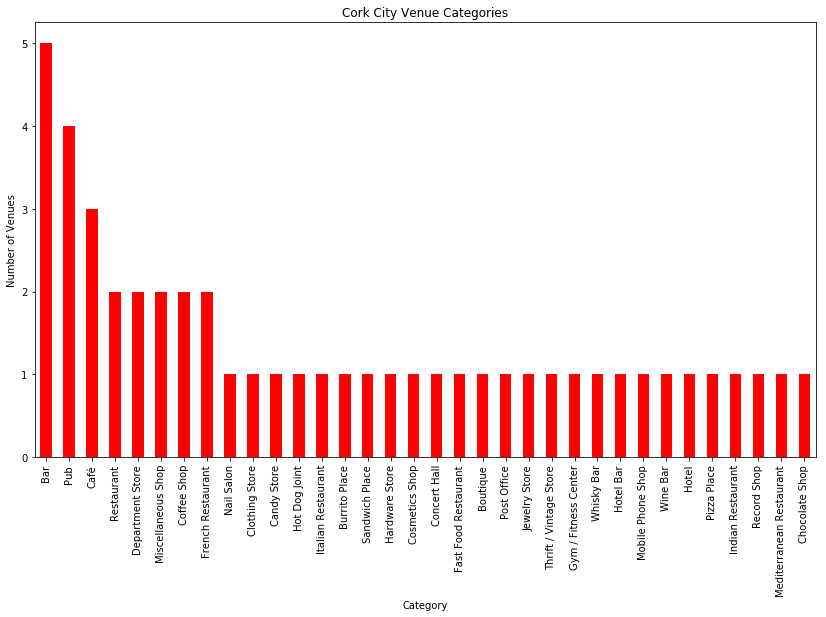

In [116]:
# Generate bar chart to show categories of venues in Cork City Centre
corccHist_df = corccFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Cork City Venue Categories")
corccHist_df.set_xlabel("Category")
corccHist_df.set_ylabel("Number of Venues")

In [117]:
# create the API request URL to serach for venues in Douglas
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    douglatitude,
    douglongitude,
    radius,
    LIMIT)
dougresults = requests.get(url).json() 
dougresults

{'meta': {'code': 200, 'requestId': '5e3b3c8b6d8c56001b8f13a4'},
 'response': {'venues': [{'id': '4b5b421ff964a52010ef28e3',
    'name': 'KC & Son & Sons',
    'location': {'address': 'Douglas Village',
     'lat': 51.877630872860195,
     'lng': -8.436373185378578,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.877630872860195,
       'lng': -8.436373185378578}],
     'distance': 27,
     'cc': 'IE',
     'city': 'Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Douglas Village', 'Cork', 'Co Cork', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d16c941735',
      'name': 'Burger Joint',
      'pluralName': 'Burger Joints',
      'shortName': 'Burgers',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '87801881'},
    'referralId': 'v-1580940463',
    'hasPerk': False},
   {'id': '4b5709b3f964a520e42328e3',
    'name': 'Bar

In [118]:
# assign relevant part of JSON to Douglas venues
dougvenues = dougresults['response']['venues']

# tranform venues into a dataframe
doug_df = json_normalize(dougvenues)
doug_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d16c941735', 'name': 'B...    False   
1  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
2  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
3  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
4  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
5  [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...    False   
6  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
7  [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...    False   
8  [{'id': '4bf58dd8d48988d145941735', 'name': 'C...    False   
9  [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...    False   

                         id        location.address location.cc location.city  \
0  4b5b421ff964a52010ef28e3         Douglas Village          IE          Cork   
1  4b5709b3f964a520e42328e3            Douglas East          IE          Cork   
2  52f6549b498e22bc130bd821      Church Rd, Douglas          IE          Cork   
3  4b8981acf964a520083d32e3                     NaN          IE           NaN   
4  54b18884498e9899feebdf8a                     NaN          IE           NaN   
5  4b93a33ff964a520294b34e3       7 Douglas Village          IE          Cork   
6  5e110d8a2810f5000807f957  3 Main Street, Douglas          IE          Cork   
7  4cf7a7ddc28df04d0366d115                 Douglas          IE          Cork   
8  5030f020e4b04de6f45235d9                     NaN          IE           NaN   
9  4b51b0b1f964a520b35227e3   East Village, Douglas          IE          Cork   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                 27   
1          Ireland                  NaN                 36   
2          Ireland                  NaN                 13   
3          Ireland                  NaN                155   
4          Ireland                  NaN                 40   
5          Ireland                  NaN                 31   
6          Ireland                  NaN                  9   
7          Ireland                  NaN                148   
8          Ireland                  NaN                 22   
9          Ireland                  NaN                143   

                          location.formattedAddress  \
0         [Douglas Village, Cork, Co Cork, Ireland]   
1            [Douglas East, Cork, Co Cork, Ireland]   
2      [Church Rd, Douglas, Cork, Co Cork, Ireland]   
3                                         [Ireland]   
4                                         [Ireland]   
5       [7 Douglas Village, Cork, Co Cork, Ireland]   
6  [3 Main Street, Douglas, Cork, Co Cork, Ireland]   
7                 [Douglas, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9   [East Village, Douglas, Cork, Co Cork, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.87763087286019...     51.877631   
1  [{'label': 'display', 'lat': 51.87715239080867...     51.877152   
2  [{'label': 'display', 'lat': 51.877363, 'lng':...     51.877363   
3  [{'label': 'display', 'lat': 51.87661353096141...     51.876614   
4  [{'label': 'display', 'lat': 51.87721838508732...     51.877218   
5  [{'label': 'display', 'lat': 51.877201, 'lng':...     51.877201   
6  [{'label': 'display', 'lat': 51.87741320452142...     51.877413   
7  [{'label': 'display', 'lat': 51.87752676229338...     51.877527   
8  [{'label': 'display', 'lat': 51.87737325766458...     51.877373   
9  [{'label': 'display', 'lat': 51.87776621123088...     51.877766   

   location.lng location.neighborhood location.postalCode location.state  \
0     -8.436373                   NaN                 NaN        Co Cork   
1     -8.436135                   NaN                 NaN        Co Cork   
2     -8.436019                   NaN                 NaN        Co Cork   
3     -8.437841                   NaN                 NaN            N

In [119]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in doug_df.columns if col.startswith('location.')] + ['id']
doug_df_filtered = doug_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
doug_df_filtered['categories'] = doug_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
doug_df_filtered.columns = [column.split('.')[-1] for column in doug_df_filtered.columns]

doug_df_filtered.head(10)

name          categories  \
0                  KC & Son & Sons        Burger Joint   
1                Barrys of Douglas                 Bar   
2                           Subway      Sandwich Place   
3                  o driscolls bar                 Bar   
4                         Palmento         Pizza Place   
5                Bullys Restaurant          Restaurant   
6                           Subway      Sandwich Place   
7  Douglas Village Shopping Centre       Shopping Mall   
8   Rose Garden Chinese Restaurant  Chinese Restaurant   
9                     East Village          Restaurant   

                  address  cc  city  country crossStreet  distance  \
0         Douglas Village  IE  Cork  Ireland         NaN        27   
1            Douglas East  IE  Cork  Ireland         NaN        36   
2      Church Rd, Douglas  IE  Cork  Ireland         NaN        13   
3                     NaN  IE   NaN  Ireland         NaN       155   
4                     NaN  IE   NaN  Ireland         NaN        40   
5       7 Douglas Village  IE  Cork  Ireland         NaN        31   
6  3 Main Street, Douglas  IE  Cork  Ireland         NaN         9   
7                 Douglas  IE  Cork  Ireland         NaN       148   
8                     NaN  IE   NaN  Ireland         NaN        22   
9   East Village, Douglas  IE  Cork  Ireland         NaN       143   

                                   formattedAddress  \
0         [Douglas Village, Cork, Co Cork, Ireland]   
1            [Douglas East, Cork, Co Cork, Ireland]   
2      [Church Rd, Douglas, Cork, Co Cork, Ireland]   
3                                         [Ireland]   
4                                         [Ireland]   
5       [7 Douglas Village, Cork, Co Cork, Ireland]   
6  [3 Main Street, Douglas, Cork, Co Cork, Ireland]   
7                 [Douglas, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9   [East Village, Douglas, Cork, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.87763087286019...  51.877631 -8.436373   
1  [{'label': 'display', 'lat': 51.87715239080867...  51.877152 -8.436135   
2  [{'label': 'display', 'lat': 51.877363, 'lng':...  51.877363 -8.436019   
3  [{'label': 'display', 'lat': 51.87661353096141...  51.876614 -8.437841   
4  [{'label': 'display', 'lat': 51.87721838508732...  51.877218 -8.436470   
5  [{'label': 'display', 'lat': 51.877201, 'lng':...  51.877201 -8.436005   
6  [{'label': 'display', 'lat': 51.87741320452142...  51.877413 -8.435980   
7  [{'label': 'display', 'lat': 51.87752676229338...  51.877527 -8.438221   
8  [{'label': 'display', 'lat': 51.87737325766458...  51.877373 -8.436347   
9  [{'label': 'display', 'lat': 51.87776621123088...  51.877766 -8.434025   

  neighborhood postalCode    state                        id  
0          NaN        NaN  Co Cork  4b5b421ff964a52010ef28e3  
1          NaN        NaN  Co Cork  4b5709b3f964a520e42328e3  
2          NaN        NaN  Co Cork  52f6549b498e22bc130bd821  
3          NaN        NaN      NaN  4b8981acf964a520083d32e3  
4          NaN        NaN      NaN  54b18884498e9899feebdf8a  
5          NaN        NaN  Co Cork  4b93a33ff964a520294b34e3  
6          NaN        NaN  Co Cork  5e110d8a2810f5000807f957  
7          NaN        NaN  Co Cork  4cf7a7ddc28df04d0366d115  
8          NaN        NaN      NaN  5030f020e4b04de6f45235d9  
9          NaN        NaN  Co Cork  4b51b0b1f964a520b35227e3

In [120]:
# Remove unnecessary columns to generate final douglas venueslistings dataframe
dougFinal_df = doug_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
dougFinal_df

name              categories  \
0                   KC & Son & Sons            Burger Joint   
1                 Barrys of Douglas                     Bar   
2                            Subway          Sandwich Place   
3                   o driscolls bar                     Bar   
4                          Palmento             Pizza Place   
5                 Bullys Restaurant              Restaurant   
6                            Subway          Sandwich Place   
7   Douglas Village Shopping Centre           Shopping Mall   
8    Rose Garden Chinese Restaurant      Chinese Restaurant   
9                      East Village              Restaurant   
10                       McDonald's    Fast Food Restaurant   
11                            Topaz             Gas Station   
12                      Cinemaworld               Multiplex   
13                   Domino's Pizza             Pizza Place   
14                Marks and Spencer           Deli / Bodega   
15                      Tesco Extra             Supermarket   
16                        Lal Quila       Indian Restaurant   
17                            Ramen        Asian Restaurant   
18         Four Star Pizza, Douglas             Pizza Place   
19                     Costa Coffee             Coffee Shop   
20                      MacCarthy’s  Furniture / Home Store   
21         Neasa Long Physiotherapy      Physical Therapist   
22           Douglas Farmers Market          Farmers Market   
23                         M&S Cafe                    Café   
24           Douglas Community Park                    Park   
25                       Marcello's      Italian Restaurant   
26                            Eco's              Restaurant   
27                          El Vino        Tapas Restaurant   
28                        12 Tables                  Bistro   
29                         I Scream          Ice Cream Shop   
30                 The South County                     Pub   
31                          Tk Maxx          Clothing Store   
32     Dennehy's Health and Fitness                     Gym   
33                   Douglas Cinena                    None   
34                        Starbucks             Coffee Shop   
35                        Puccino's                    Café   
36                           Haveli       Indian Restaurant   
37                              KFC    Fast Food Restaurant   
38             Animal Care Hospital            Veterinarian   
39                        Quigley's             Coffee Shop   
40    Bamboo House Chinese Takeaway                    None   
41    O'Sullivan's Bar & Restaurant                     Bar   
42                           Dino's       Fish & Chips Shop   
43            BB's Coffee & Muffins             Coffee Shop   
44                  Golden Elephant         Thai Restaurant   
45          La Calavera Burrito Bar           Burrito Place   
46                      Fudi & More      Chinese Restaurant   
47                  Marks & Spencer           Grocery Store   
48           O'Brien's Sandwich Bar          Sandwich Place   
49        Indoor Playground Douglas              Playground   

                                              address  distance        lat  \
0                                     Douglas Village        27  51.877631   
1                                        Douglas East        36  51.877152   
2                                  Church Rd, Douglas        13  51.877363   
3                                                 NaN       155  51.876614   
4                                                 NaN        40  51.877218   
5                                   7 Douglas Village        31  51.877201   
6                              3 Main Street, Douglas         9  51.877413   
7                                             Douglas       148  51.877527   
8                                                 NaN        22  51.877373   
9                               East 

Text(0, 0.5, 'Number of Venues')

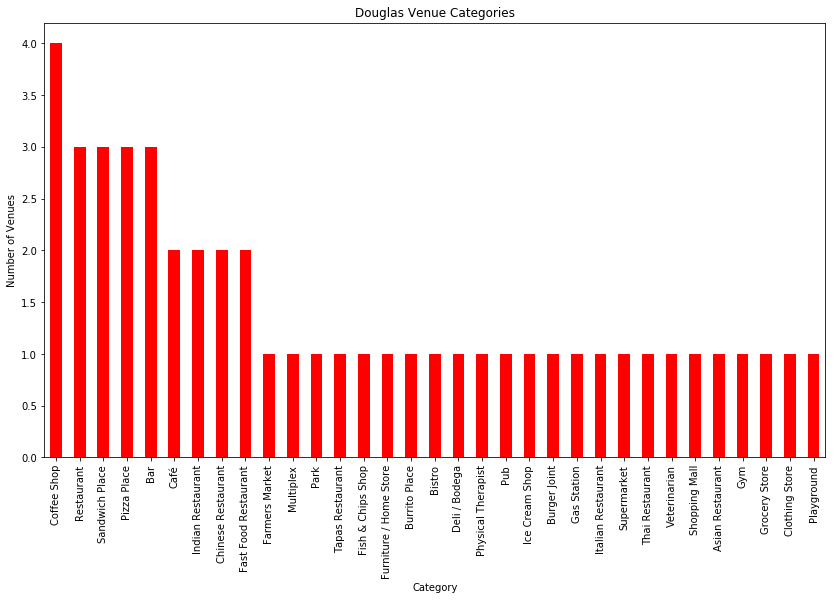

In [121]:
# Generate bar chart to show categories of venues in Douglas
dougHist_df = dougFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Douglas Venue Categories")
dougHist_df.set_xlabel("Category")
dougHist_df.set_ylabel("Number of Venues")

In [122]:
# create the API request URL to serach for venues in Blarney
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    blarlatitude,
    blarlongitude,
    radius,
    LIMIT)
blarresults = requests.get(url).json() 
blarresults

{'meta': {'code': 200, 'requestId': '5e3b3d14df2774001bfc436e'},
 'response': {'venues': [{'id': '4c94c11572dd224b26aa9c91',
    'name': "Christy's",
    'location': {'address': 'Blarney Woollen Mills Hotel',
     'lat': 51.93318421852336,
     'lng': -8.565922840648076,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.93318421852336,
       'lng': -8.565922840648076}],
     'distance': 54,
     'cc': 'IE',
     'city': 'Co Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Blarney Woollen Mills Hotel',
      'Co Cork',
      'Co Cork',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d116941735',
      'name': 'Bar',
      'pluralName': 'Bars',
      'shortName': 'Bar',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580940472',
    'hasPerk': False},
   {'id': '4bbef73182a2ef3b9d0d2cd2',
    'name': 'Blarney Castle',
   

In [123]:
# assign relevant part of JSON to Blarney venues
blarvenues = blarresults['response']['venues']

# tranform venues into a dataframe
blar_df = json_normalize(blarvenues)
blar_df.head()

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
1  [{'id': '50aaa49e4b90af0d42d5de11', 'name': 'C...    False   
2  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
3  [{'id': '4bf58dd8d48988d103951735', 'name': 'C...    False   
4  [{'id': '4bf58dd8d48988d132941735', 'name': 'C...    False   

                         id             location.address location.cc  \
0  4c94c11572dd224b26aa9c91  Blarney Woollen Mills Hotel          IE   
1  4bbef73182a2ef3b9d0d2cd2          Caisleán na Blarnan          IE   
2  4be14096a7380f479a8d19b0                   The Square          IE   
3  4b5c7aa1f964a520d83129e3               Millstream Row          IE   
4  4f2d7084e4b0dbffdc3c0f7e                      Blarney          IE   

  location.city location.country location.crossStreet  location.distance  \
0       Co Cork          Ireland                  NaN                 54   
1       Blarney          Ireland                  NaN                250   
2       Blarney          Ireland                  NaN                 74   
3       Blarney          Ireland                  NaN                 71   
4           NaN          Ireland                  NaN               2226   

                           location.formattedAddress  \
0  [Blarney Woollen Mills Hotel, Co Cork, Co Cork...   
1   [Caisleán na Blarnan, Blarney, Co Cork, Ireland]   
2            [The Square, Blarney, Co Cork, Ireland]   
3        [Millstream Row, Blarney, Co Cork, Ireland]   
4                                 [Blarney, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.93318421852336...     51.933184   
1  [{'label': 'display', 'lat': 51.93141455688293...     51.931415   
2  [{'label': 'display', 'lat': 51.93312512346203...     51.933125   
3  [{'label': 'display', 'lat': 51.93313482234061...     51.933135   
4  [{'label': 'display', 'lat': 51.94853, 'lng': ...     51.948530   

   location.lng location.state  \
0     -8.565923        Co Cork   
1     -8.568518        Co Cork   
2     -8.567697        Co Cork   
3     -8.565694        Co Cork   
4     -8.545540            NaN   

                                                name    referralId  \
0                                          Christy's  v-1580940472   
1                                     Blarney Castle  v-1580940472   
2                                      Muskerry Arms  v-1580940472   
3                              Blarney Woollen Mills  v-1580940472   
4  Catholic Church of the Immaculate Conception (...  v-1580940472   

  venuePage.id  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [124]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in blar_df.columns if col.startswith('location.')] + ['id']
blar_df_filtered = blar_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
blar_df_filtered['categories'] = blar_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
blar_df_filtered.columns = [column.split('.')[-1] for column in blar_df_filtered.columns]

blar_df_filtered.head(10)

name        categories  \
0                                          Christy's               Bar   
1                                     Blarney Castle            Castle   
2                                      Muskerry Arms               Pub   
3                              Blarney Woollen Mills    Clothing Store   
4  Catholic Church of the Immaculate Conception (...            Church   
5                               Blarney Castle Hotel             Hotel   
6                                             Centra     Grocery Store   
7                                The Mill Restaurant        Restaurant   
8                                            Dentist  Dentist's Office   
9                                     Blarney Square              Park   

                       address  cc     city  country      crossStreet  \
0  Blarney Woollen Mills Hotel  IE  Co Cork  Ireland              NaN   
1          Caisleán na Blarnan  IE  Blarney  Ireland              NaN   
2                   The Square  IE  Blarney  Ireland              NaN   
3               Millstream Row  IE  Blarney  Ireland              NaN   
4                      Blarney  IE      NaN  Ireland              NaN   
5  The Square, Blarney Village  IE  Co Cork  Ireland  Blarney Village   
6                          NaN  IE  Blarney  Ireland              NaN   
7  Blarney Woollen Mills Hotel  IE  Blarney  Ireland              NaN   
8                      blarney  IE      NaN  Ireland              NaN   
9                          NaN  IE  Blarney  Ireland              NaN   

   distance                                   formattedAddress  \
0        54  [Blarney Woollen Mills Hotel, Co Cork, Co Cork...   
1       250   [Caisleán na Blarnan, Blarney, Co Cork, Ireland]   
2        74            [The Square, Blarney, Co Cork, Ireland]   
3        71        [Millstream Row, Blarney, Co Cork, Ireland]   
4      2226                                 [Blarney, Ireland]   
5       109  [The Square, Blarney Village (Blarney Village)...   
6        94                        [Blarney, Co Cork, Ireland]   
7        96  [Blarney Woollen Mills Hotel, Blarney, Co Cork...   
8       151                                 [blarney, Ireland]   
9       144                        [Blarney, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.93318421852336...  51.933184 -8.565923   
1  [{'label': 'display', 'lat': 51.93141455688293...  51.931415 -8.568518   
2  [{'label': 'display', 'lat': 51.93312512346203...  51.933125 -8.567697   
3  [{'label': 'display', 'lat': 51.93313482234061...  51.933135 -8.565694   
4  [{'label': 'display', 'lat': 51.94853, 'lng': ...  51.948530 -8.545540   
5  [{'label': 'display', 'lat': 51.93242918656407...  51.932429 -8.567205   
6  [{'label': 'display', 'lat': 51.933083, 'lng':...  51.933083 -8.567974   
7  [{'label': 'display', 'lat': 51.93311595520374...  51.933116 -8.565317   
8  [{'label': 'display', 'lat': 51.9328548386693,...  51.932855 -8.568727   
9  [{'label': 'display', 'lat': 51.932462, 'lng':...  51.932462 -8.568209   

     state                        id  
0  Co Cork  4c94c11572dd224b26aa9c91  
1  Co Cork  4bbef73182a2ef3b9d0d2cd2  
2  Co Cork  4be14096a7380f479a8d19b0  
3  Co Cork  4b5c7aa1f964a520d83129e3  
4      NaN  4f2d7084e4b0dbffdc3c0f7e  
5  Co Cork  4cd5823f886cb60c0e5e8489  
6  Co Cork  5b01884c295513002c37f376  
7  Co Cork  4f6b2effe4b0f7fc5483a17b  
8      NaN  51fb6880498ec0752d4dfc71  
9  Co Cork  5a3fe217535d6f23fc98841f

In [125]:
# Remove unnecessary columns to generate final Blarney venues listings dataframe
blarFinal_df = blar_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'state'], axis=1).reset_index(drop=True)
blarFinal_df

name  \
0                                           Christy's   
1                                      Blarney Castle   
2                                       Muskerry Arms   
3                               Blarney Woollen Mills   
4   Catholic Church of the Immaculate Conception (...   
5                                Blarney Castle Hotel   
6                                              Centra   
7                                 The Mill Restaurant   
8                                             Dentist   
9                                      Blarney Square   
10                                        Meadow Bank   
11                                           Claddagh   
12                          Blarney Chocolate Factory   
13                        Blarney Woollen Mills Hotel   
14                        The Old Blarney Post Office   
15                   Johnny's At Blarney Castle Hotel   
16                                    Bus 215 To Cork   
17                           Muskerry Arms Guesthouse   
18                                          Suko Thai   
19                         Lantern Chinese Restaurant   
20                                  The Blarney Stone   
21                                Blarney Post Office   
22                                           EATin'IT   
23                                          The Quill   
24                                  Collins SuperValu   
25                                   Coach House Café   
26                                   The Square Table   
27                                               Erin   
28                                         Rock Close   
29                      Scoil Mhuire Gan Smal Blarney   
30                                     Blake's Centra   
31                                      Blarney House   
32                        Gleann Fia, By Clancy Homes   
33                                      Poison Garden   
34                                     The Blue Haven   
35                         Hc21 Blarney Business Park   
36                                The White House B&B   
37                                   Horses Graveyard   
38                                        Badger Cave   
39                                 Blarney NCT Centre   
40                               Shournagh Child Care   
41                                           Pharmacy   
42                                          Tung Sing   
43                                             Church   
44                   Blarney Caravan and Camping Park   
45                                           Insomnia   
46                                     Doctor Surgery   
47                                    CIT GAA Stadium   
48               Camp Junction House Bed & Breakfast.   
49                                     Blarney United   

                    categories                      address  distance  \
0                          Bar  Blarney Woollen Mills Hotel        54   
1                       Castle          Caisleán na Blarnan       250   
2                          Pub                   The Square        74   
3               Clothing Store               Millstream Row        71   
4                       Church                      Blarney      2226   
5                        Hotel  The Square, Blarney Village       109   
6                Grocery Store                          NaN        94   
7                   Restaurant  Blarney Woollen Mills Hotel        96   
8             Dentist's Office                      blarney       151   
9                         Park                          NaN       144   
10             Bed & Breakfast                          NaN       139   
11          Italian Restaurant                          NaN        56   
12              Ice Cream Shop                          NaN       157   
13                       Hotel                      Blarney       134   
14                        Café                

Text(0, 0.5, 'Number of Venues')

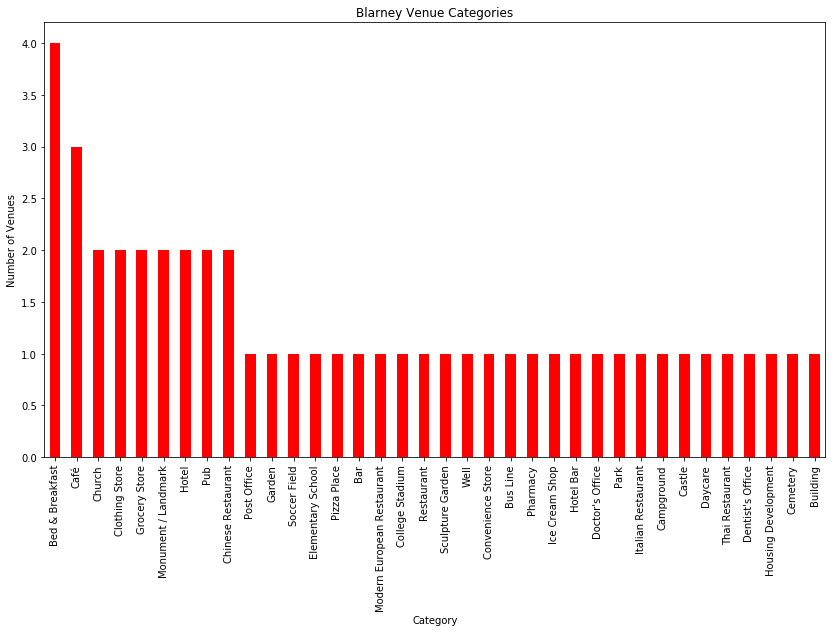

In [126]:
# Generate bar chart to show categories of venues in Blarney
blarHist_df = blarFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Blarney Venue Categories")
blarHist_df.set_xlabel("Category")
blarHist_df.set_ylabel("Number of Venues")